# Detecção de Falhas Mecânicas - MAFAULDA Dataset

## Objetivo
Este notebook apresenta uma solução completa para detecção de falhas mecânicas utilizando o banco de dados MAFAULDA, que contém séries temporais multivariadas capturadas por sensores no simulador de falhas mecânicas MFS (Machinery Fault Simulator).

## Estrutura do Projeto
1. **Importação dos Dados**
2. **Análise Exploratória dos Dados**
3. **Pré-processamento dos Dados**
4. **Escolha do modelo, treinamento, validação e avaliação.**


## 1. Importação dos Dados

### 1.1 Bibliotecas Necessárias

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc  

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss, ConfusionMatrixDisplay, roc_curve, auc
)

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')


### 1.2 Definição dos Caminhos dos Dados

In [2]:
# Caminhos base
base_path = "d:/Case-SEMEQ/"
normal_path = os.path.join(base_path, "normal")
imbalance_path = os.path.join(base_path, "imbalance")

# Arquivos de operação normal
normal_file_names = glob.glob(os.path.join(normal_path, '*.csv'))

# Arquivos de desbalanceamento
imbalance_file_names_6g = glob.glob(os.path.join(imbalance_path, '6g', '*.csv'))
imbalance_file_names_10g = glob.glob(os.path.join(imbalance_path, '10g', '*.csv'))
imbalance_file_names_15g = glob.glob(os.path.join(imbalance_path, '15g', '*.csv'))
imbalance_file_names_20g = glob.glob(os.path.join(imbalance_path, '20g', '*.csv'))
imbalance_file_names_25g = glob.glob(os.path.join(imbalance_path, '25g', '*.csv'))
imbalance_file_names_30g = glob.glob(os.path.join(imbalance_path, '30g', '*.csv'))
imbalance_file_names_35g = glob.glob(os.path.join(imbalance_path, '35g', '*.csv'))

# Verificação
print(f"Arquivos encontrados:")
print(f"  - Normal: {len(normal_file_names)} arquivos")
print(f"  - Desbalanceamento 6g: {len(imbalance_file_names_6g)} arquivos")
print(f"  - Desbalanceamento 10g: {len(imbalance_file_names_10g)} arquivos")
print(f"  - Desbalanceamento 15g: {len(imbalance_file_names_15g)} arquivos")
print(f"  - Desbalanceamento 20g: {len(imbalance_file_names_20g)} arquivos")
print(f"  - Desbalanceamento 25g: {len(imbalance_file_names_25g)} arquivos")
print(f"  - Desbalanceamento 30g: {len(imbalance_file_names_30g)} arquivos")
print(f"  - Desbalanceamento 35g: {len(imbalance_file_names_35g)} arquivos")

Arquivos encontrados:
  - Normal: 49 arquivos
  - Desbalanceamento 6g: 49 arquivos
  - Desbalanceamento 10g: 48 arquivos
  - Desbalanceamento 15g: 48 arquivos
  - Desbalanceamento 20g: 49 arquivos
  - Desbalanceamento 25g: 47 arquivos
  - Desbalanceamento 30g: 47 arquivos
  - Desbalanceamento 35g: 45 arquivos


### 1.3 Funções para Leitura e Downsampling dos Dados

**Justificativa:** Para evitar problemas de memória, apliquei **downsampling durante a leitura** dos arquivos. Isso reduz drasticamente o uso de memória ao agregar blocos de dados pela média.

- Taxa de amostragem original: 50 kHz (50.000 amostras/segundo)
- Downsampling rate: 1.000 (reduz para 50 Hz efetivo)
- Isso reduz o volume de dados em ~1.000x, tornando viável o processamento em memória
- A média de blocos preserva características importantes do sinal

In [3]:
def downSampler(data, start_idx, sampling_rate):
    """
    Reduz a taxa de amostragem dos dados calculando a média de blocos.
    
    Parâmetros:
    -----------
    data : pd.DataFrame
        DataFrame com os dados originais
    start_idx : int
        Índice inicial
    sampling_rate : int
        Tamanho do bloco para downsampling (número de linhas a agregar)
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame com dados reduzidos
    """
    data_decreased = []
    a = start_idx
    b = sampling_rate
    
    # Processar blocos
    while b <= len(data):
        # Calcular média do bloco
        block_mean = data.iloc[a:b, :].mean().values
        data_decreased.append(block_mean)
        a += sampling_rate
        b += sampling_rate
    
    # Converter para DataFrame
    return pd.DataFrame(data_decreased, columns=data.columns)


def dataReader(pathes, downsample_rate=1000, verbose=True):
    """
    Parâmetros:
    -----------
    pathes : list
        Lista de caminhos dos arquivos CSV a serem lidos
    downsample_rate : int
        Taxa de downsampling (agrupa N linhas em 1 pela média)
        Padrão: 1000 (reduz 50kHz para ~50Hz)
    verbose : bool
        Se True, exibe informações sobre o progresso
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame concatenado com dados reduzidos
    """
    all_data = []
    
    for i, path in enumerate(pathes):
        if verbose and (i + 1) % 10 == 0:
            print(f"  Processando arquivo {i + 1}/{len(pathes)}...")
        
        # Leitura do arquivo
        lowdata = pd.read_csv(path, header=None)
        
        # Aplica downsampling imediatamente
        downsampled = downSampler(lowdata, 0, downsample_rate)
        
        # Adiciona à lista
        all_data.append(downsampled)
        
        # Libera memória
        del lowdata, downsampled
        
        # Força coleta de lixo a cada 10 arquivos
        if (i + 1) % 10 == 0:
            gc.collect()
    
    data = pd.concat(all_data, ignore_index=True)
    
    # Liberamemória
    del all_data
    gc.collect()
    
    return data

### 1.4 Carregamento dos Dados

**Justificativa:** Carregamos os dados de cada condição separadamente com downsampling aplicado durante a leitura. Isso mantém a rastreabilidade e torna o processamento viável em memória.

In [4]:
data_normal = dataReader(normal_file_names)
data_6g = dataReader(imbalance_file_names_6g)
data_10g = dataReader(imbalance_file_names_10g)
data_15g = dataReader(imbalance_file_names_15g)
data_20g = dataReader(imbalance_file_names_20g)
data_25g = dataReader(imbalance_file_names_25g)
data_30g = dataReader(imbalance_file_names_30g)
data_35g = dataReader(imbalance_file_names_35g)

  Processando arquivo 10/49...
  Processando arquivo 20/49...
  Processando arquivo 30/49...
  Processando arquivo 40/49...
  Processando arquivo 10/49...
  Processando arquivo 20/49...
  Processando arquivo 30/49...
  Processando arquivo 40/49...
  Processando arquivo 10/48...
  Processando arquivo 20/48...
  Processando arquivo 30/48...
  Processando arquivo 40/48...
  Processando arquivo 10/48...
  Processando arquivo 20/48...
  Processando arquivo 30/48...
  Processando arquivo 40/48...
  Processando arquivo 10/49...
  Processando arquivo 20/49...
  Processando arquivo 30/49...
  Processando arquivo 40/49...
  Processando arquivo 10/47...
  Processando arquivo 20/47...
  Processando arquivo 30/47...
  Processando arquivo 40/47...
  Processando arquivo 10/47...
  Processando arquivo 20/47...
  Processando arquivo 30/47...
  Processando arquivo 40/47...
  Processando arquivo 10/45...
  Processando arquivo 20/45...
  Processando arquivo 30/45...
  Processando arquivo 40/45...


### 1.5 Visualização Inicial dos Dados

In [5]:
# Verificar estrutura dos dados
datasets = {
    'Normal': data_normal,
    'Desbalanceamento 6g': data_6g,
    'Desbalanceamento 10g': data_10g,
    'Desbalanceamento 15g': data_15g,
    'Desbalanceamento 20g': data_20g,
    'Desbalanceamento 25g': data_25g,
    'Desbalanceamento 30g': data_30g,
    'Desbalanceamento 35g': data_35g
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Colunas (Sensores): {df.shape[1]}")
    print(f"  Linhas (Amostras): {df.shape[0]:,}")
    print(f"  Memória: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Normal:
  Shape: (12250, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 12,250
  Memória: 0.75 MB

Desbalanceamento 6g:
  Shape: (12250, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 12,250
  Memória: 0.75 MB

Desbalanceamento 10g:
  Shape: (12000, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 12,000
  Memória: 0.73 MB

Desbalanceamento 15g:
  Shape: (12000, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 12,000
  Memória: 0.73 MB

Desbalanceamento 20g:
  Shape: (12250, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 12,250
  Memória: 0.75 MB

Desbalanceamento 25g:
  Shape: (11750, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 11,750
  Memória: 0.72 MB

Desbalanceamento 30g:
  Shape: (11750, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 11,750
  Memória: 0.72 MB

Desbalanceamento 35g:
  Shape: (11250, 8)
  Colunas (Sensores): 8
  Linhas (Amostras): 11,250
  Memória: 0.69 MB


In [6]:
# Visualizar primeiras linhas de um dataset (Normal)
display(data_normal.head())

0         1         2         3         4         5         6  \
0  1.203398 -0.122523 -0.000420 -0.004745 -0.042759  0.008953 -0.058694   
1 -0.584449 -0.176627 -0.030719 -0.002918  0.030208  0.001675 -0.057903   
2 -0.551016  0.063121  0.009094  0.000020  0.061094 -0.001865 -0.073677   
3 -0.501559  0.160005 -0.007349  0.006786  0.343338  0.007399  0.038513   
4  1.645809  0.005535  0.033461 -0.000279  0.675661  0.011043  0.175079   

          7  
0  0.010479  
1  0.032378  
2  0.000883  
3 -0.009840  
4  0.009984

## 2. Análise Exploratória dos Dados
Uma análise exploratória detalhada para entender as características dos dados e orientar as decisões de pré-processamento e modelagem.


### 2.1 Análise Exploratória Inicial

In [7]:
# Estatísticas descritivas para cada condição
display(data_normal.describe())
display(data_6g.describe())

0             1             2             3             4  \
count  12250.000000  12250.000000  12250.000000  12250.000000  12250.000000   
mean       0.000157      0.007892     -0.000466      0.000373      0.014837   
std        0.467771      0.078998      0.033040      0.012127      0.504562   
min       -0.724899     -0.426309     -0.116569     -0.040987     -2.469531   
25%       -0.440494     -0.039184     -0.020562     -0.005930     -0.231647   
50%        0.003193      0.005477     -0.000226      0.000503      0.022830   
75%        0.244947      0.054003      0.018647      0.006787      0.258211   
max        1.787735      0.415604      0.112452      0.041628      2.596435   

                  5             6             7  
count  12250.000000  12250.000000  12250.000000  
mean       0.003021      0.018774      0.012278  
std        0.018117      0.318880      0.009722  
min       -0.186268     -1.785392     -0.051090  
25%       -0.004539     -0.165799      0.006276  
50%        0.002606      0.016062      0.011695  
75%        0.010211      0.201920      0.017876  
max        0.174232      1.698928      0.086709

0             1             2             3             4  \
count  12250.000000  12250.000000  12250.000000  12250.000000  12250.000000   
mean      -0.000002      0.003056      0.000269      0.000907      0.007707   
std        0.449423      0.086944      0.068452      0.026547      0.080496   
min       -0.718738     -0.280641     -0.265920     -0.094004     -0.494348   
25%       -0.336730     -0.053954     -0.030154     -0.014009     -0.032250   
50%        0.005916      0.001191      0.000007      0.000782      0.012228   
75%        0.234785      0.057695      0.028155      0.015704      0.052714   
max        1.554260      0.317395      0.256130      0.098729      0.384748   

                  5             6             7  
count  12250.000000  12250.000000  12250.000000  
mean       0.003113      0.045957      0.014028  
std        0.015920      0.607595      0.009521  
min       -0.087293     -3.691198     -0.013153  
25%       -0.005825     -0.282298      0.008767  
50%        0.003491      0.045512      0.013815  
75%        0.012571      0.375389      0.019052  
max        0.081580      3.206868      0.049742

In [8]:
data_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250 entries, 0 to 12249
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12250 non-null  float64
 1   1       12250 non-null  float64
 2   2       12250 non-null  float64
 3   3       12250 non-null  float64
 4   4       12250 non-null  float64
 5   5       12250 non-null  float64
 6   6       12250 non-null  float64
 7   7       12250 non-null  float64
dtypes: float64(8)
memory usage: 765.8 KB


### 2.2 Visualização das Séries Temporais

A visualização das séries temporais permite identificar padrões, tendências, sazonalidade e anomalias nos dados.

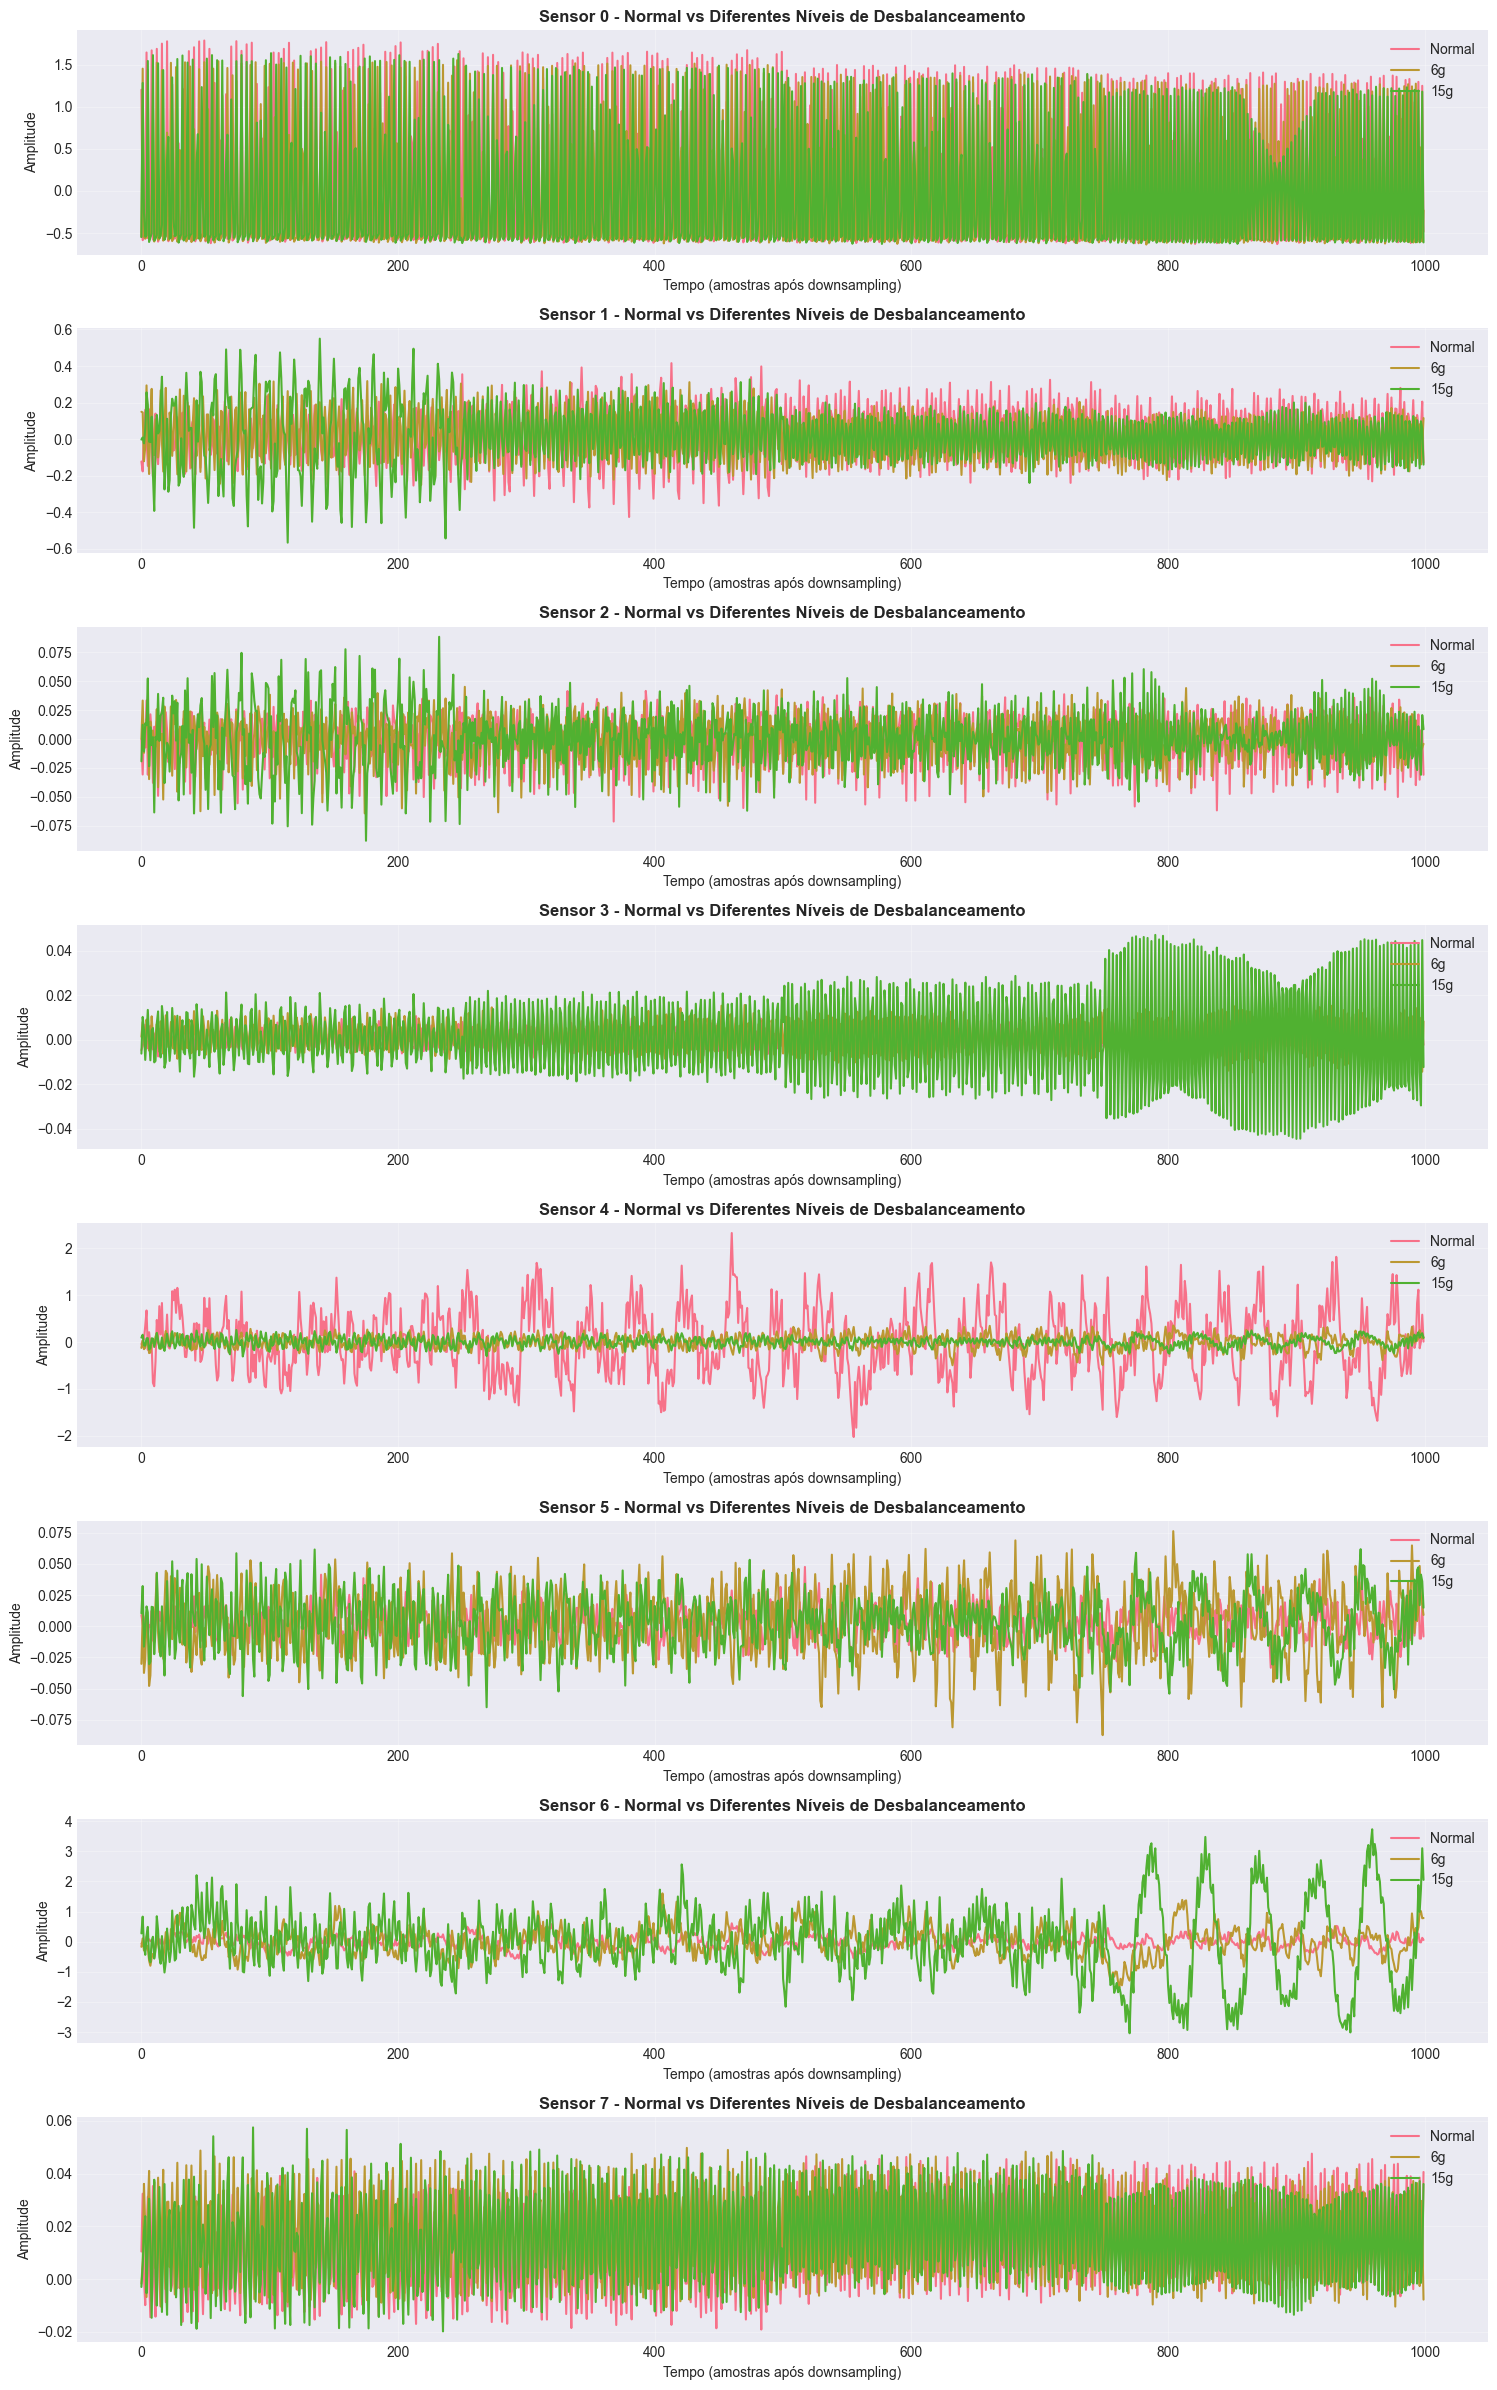

In [9]:
def plot_time_series_comparison(data_dict, sample_size=1000, title="Comparação de Séries Temporais"):
    """
    Plota séries temporais de diferentes condições para comparação.
    
    Parâmetros:
    -----------
    data_dict : dict
        Dicionário com nome da condição como chave e DataFrame como valor
    sample_size : int
        Número de observações a plotar
    title : str
        Título do gráfico
    """
    num_sensors = list(data_dict.values())[0].shape[1]
    
    fig, axes = plt.subplots(num_sensors, 1, figsize=(15, 3 * num_sensors))
    
    if num_sensors == 1:
        axes = [axes]
    
    for sensor_idx in range(num_sensors):
        for condition_name, df in data_dict.items():
            sample = df.iloc[:sample_size, sensor_idx]
            axes[sensor_idx].plot(sample, label=condition_name, alpha=1)
        
        axes[sensor_idx].set_title(f'Sensor {sensor_idx} - {title}', fontsize=12, fontweight='bold')
        axes[sensor_idx].set_xlabel('Tempo (amostras após downsampling)')
        axes[sensor_idx].set_ylabel('Amplitude')
        axes[sensor_idx].legend(loc='upper right')
        axes[sensor_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Comparar normal vs desbalanceamentos 
comparison_data = {
    'Normal': data_normal,
    '6g': data_6g,
    '15g': data_15g,
    #'25g': data_25g,
    #'35g': data_35g
}

plot_time_series_comparison(comparison_data, sample_size=1000, 
                            title="Normal vs Diferentes Níveis de Desbalanceamento")

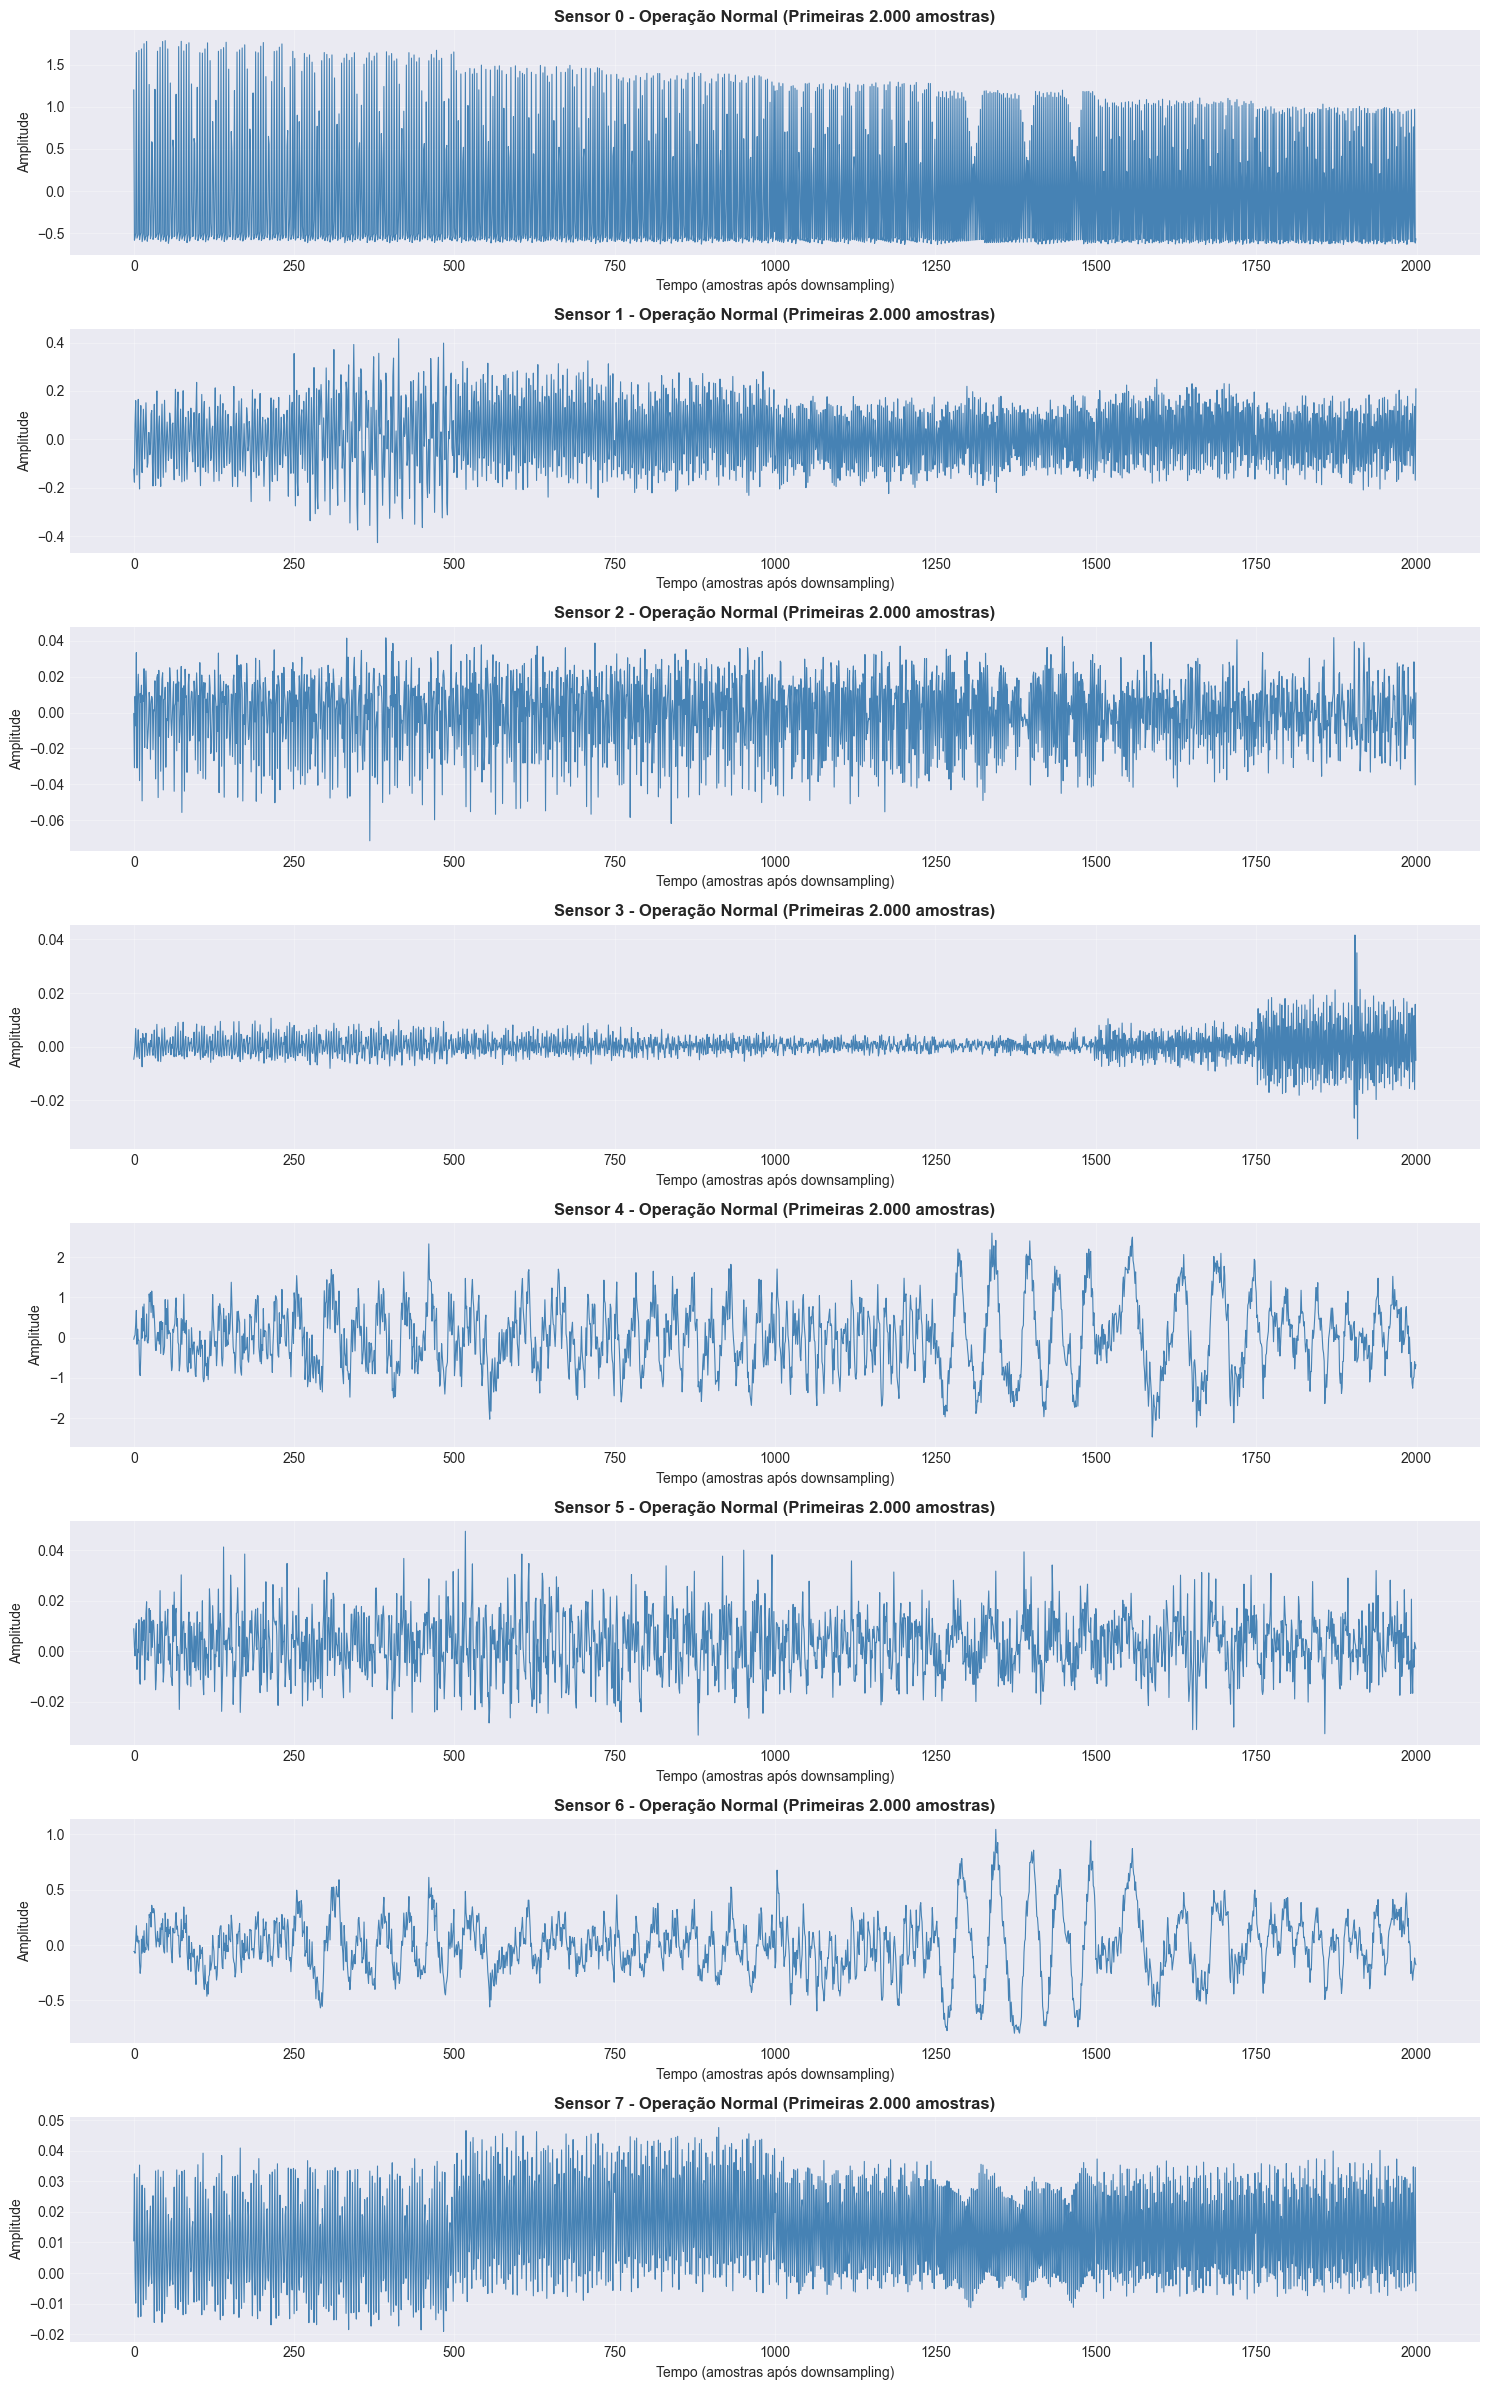

In [10]:
# Visualização detalhada de uma única condição (Normal)
fig, axes = plt.subplots(data_normal.shape[1], 1, figsize=(15, 3 * data_normal.shape[1]))

if data_normal.shape[1] == 1:
    axes = [axes]

for i in range(data_normal.shape[1]):
    axes[i].plot(data_normal.iloc[:2000, i], color='steelblue', linewidth=0.8)
    axes[i].set_title(f'Sensor {i} - Operação Normal (Primeiras 2.000 amostras)', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Tempo (amostras após downsampling)')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Análise de Distribuição

Verificar se os dados seguem uma distribuição normal é importante para escolher técnicas de pré-processamento e modelos adequados. Usei histogramas, Q-Q plots e testes estatísticos.

In [11]:
def analyze_distribution(data, condition_name, num_sensors=None):
    """
    Analisa a distribuição dos dados de cada sensor.
    
    Parâmetros:
    -----------
    data : pd.DataFrame
        DataFrame com os dados dos sensores
    condition_name : str
        Nome da condição (para título)
    num_sensors : int
        Número de sensores a analisar (None = todos)
    """
    if num_sensors is None:
        num_sensors = data.shape[1]
    
    fig = plt.figure(figsize=(18, 4 * num_sensors))
    gs = GridSpec(num_sensors, 3, figure=fig)
    
    for i in range(num_sensors):
        sensor_data = data.iloc[:, i].dropna()
        
        # Histograma
        ax1 = fig.add_subplot(gs[i, 0])
        ax1.hist(sensor_data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        ax1.set_title(f'Sensor {i} - Histograma', fontweight='bold')
        ax1.set_xlabel('Amplitude')
        ax1.set_ylabel('Frequência')
        ax1.grid(True, alpha=0.3)
        
        # Q-Q Plot
        ax2 = fig.add_subplot(gs[i, 1])
        stats.probplot(sensor_data, dist="norm", plot=ax2)
        ax2.set_title(f'Sensor {i} - Q-Q Plot', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Box Plot
        ax3 = fig.add_subplot(gs[i, 2])
        ax3.boxplot(sensor_data, vert=True)
        ax3.set_title(f'Sensor {i} - Box Plot', fontweight='bold')
        ax3.set_ylabel('Amplitude')
        ax3.grid(True, alpha=0.3)
        
        # Teste de Normalidade (Shapiro-Wilk)
        # Usar amostra menor para o teste (máximo 5000 observações)
        sample_size = min(5000, len(sensor_data))
        sample = sensor_data.sample(sample_size, random_state=42)
        stat, p_value = stats.shapiro(sample)
        
        print(f"\nSensor {i}:")
        print(f"  Média: {sensor_data.mean():.4f}")
        print(f"  Desvio Padrão: {sensor_data.std():.4f}")
        print(f"  Assimetria (Skewness): {stats.skew(sensor_data):.4f}")
        print(f"  Curtose (Kurtosis): {stats.kurtosis(sensor_data):.4f}")
        print(f"  Teste Shapiro-Wilk: estatística={stat:.4f}, p-valor={p_value:.4e}")
        
        if p_value > 0.05:
            print(f"  → Distribuição NORMAL (p-valor > 0.05)")
        else:
            print(f"  → Distribuição NÃO NORMAL (p-valor < 0.05)")
    
    plt.tight_layout()
    plt.show()


Sensor 0:
  Média: 0.0002
  Desvio Padrão: 0.4678
  Assimetria (Skewness): 0.6072
  Curtose (Kurtosis): 0.6036
  Teste Shapiro-Wilk: estatística=0.9395, p-valor=3.9801e-41
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 1:
  Média: 0.0079
  Desvio Padrão: 0.0790
  Assimetria (Skewness): 0.1243
  Curtose (Kurtosis): 1.0972
  Teste Shapiro-Wilk: estatística=0.9918, p-valor=2.0555e-16
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 2:
  Média: -0.0005
  Desvio Padrão: 0.0330
  Assimetria (Skewness): 0.0482
  Curtose (Kurtosis): 0.6569
  Teste Shapiro-Wilk: estatística=0.9927, p-valor=2.4037e-15
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 3:
  Média: 0.0004
  Desvio Padrão: 0.0121
  Assimetria (Skewness): -0.0170
  Curtose (Kurtosis): 0.6536
  Teste Shapiro-Wilk: estatística=0.9881, p-valor=3.6040e-20
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 4:
  Média: 0.0148
  Desvio Padrão: 0.5046
  Assimetria (Skewness): 0.0810
  Curtose (Kurtosis): 2.0677
  Teste Shapir

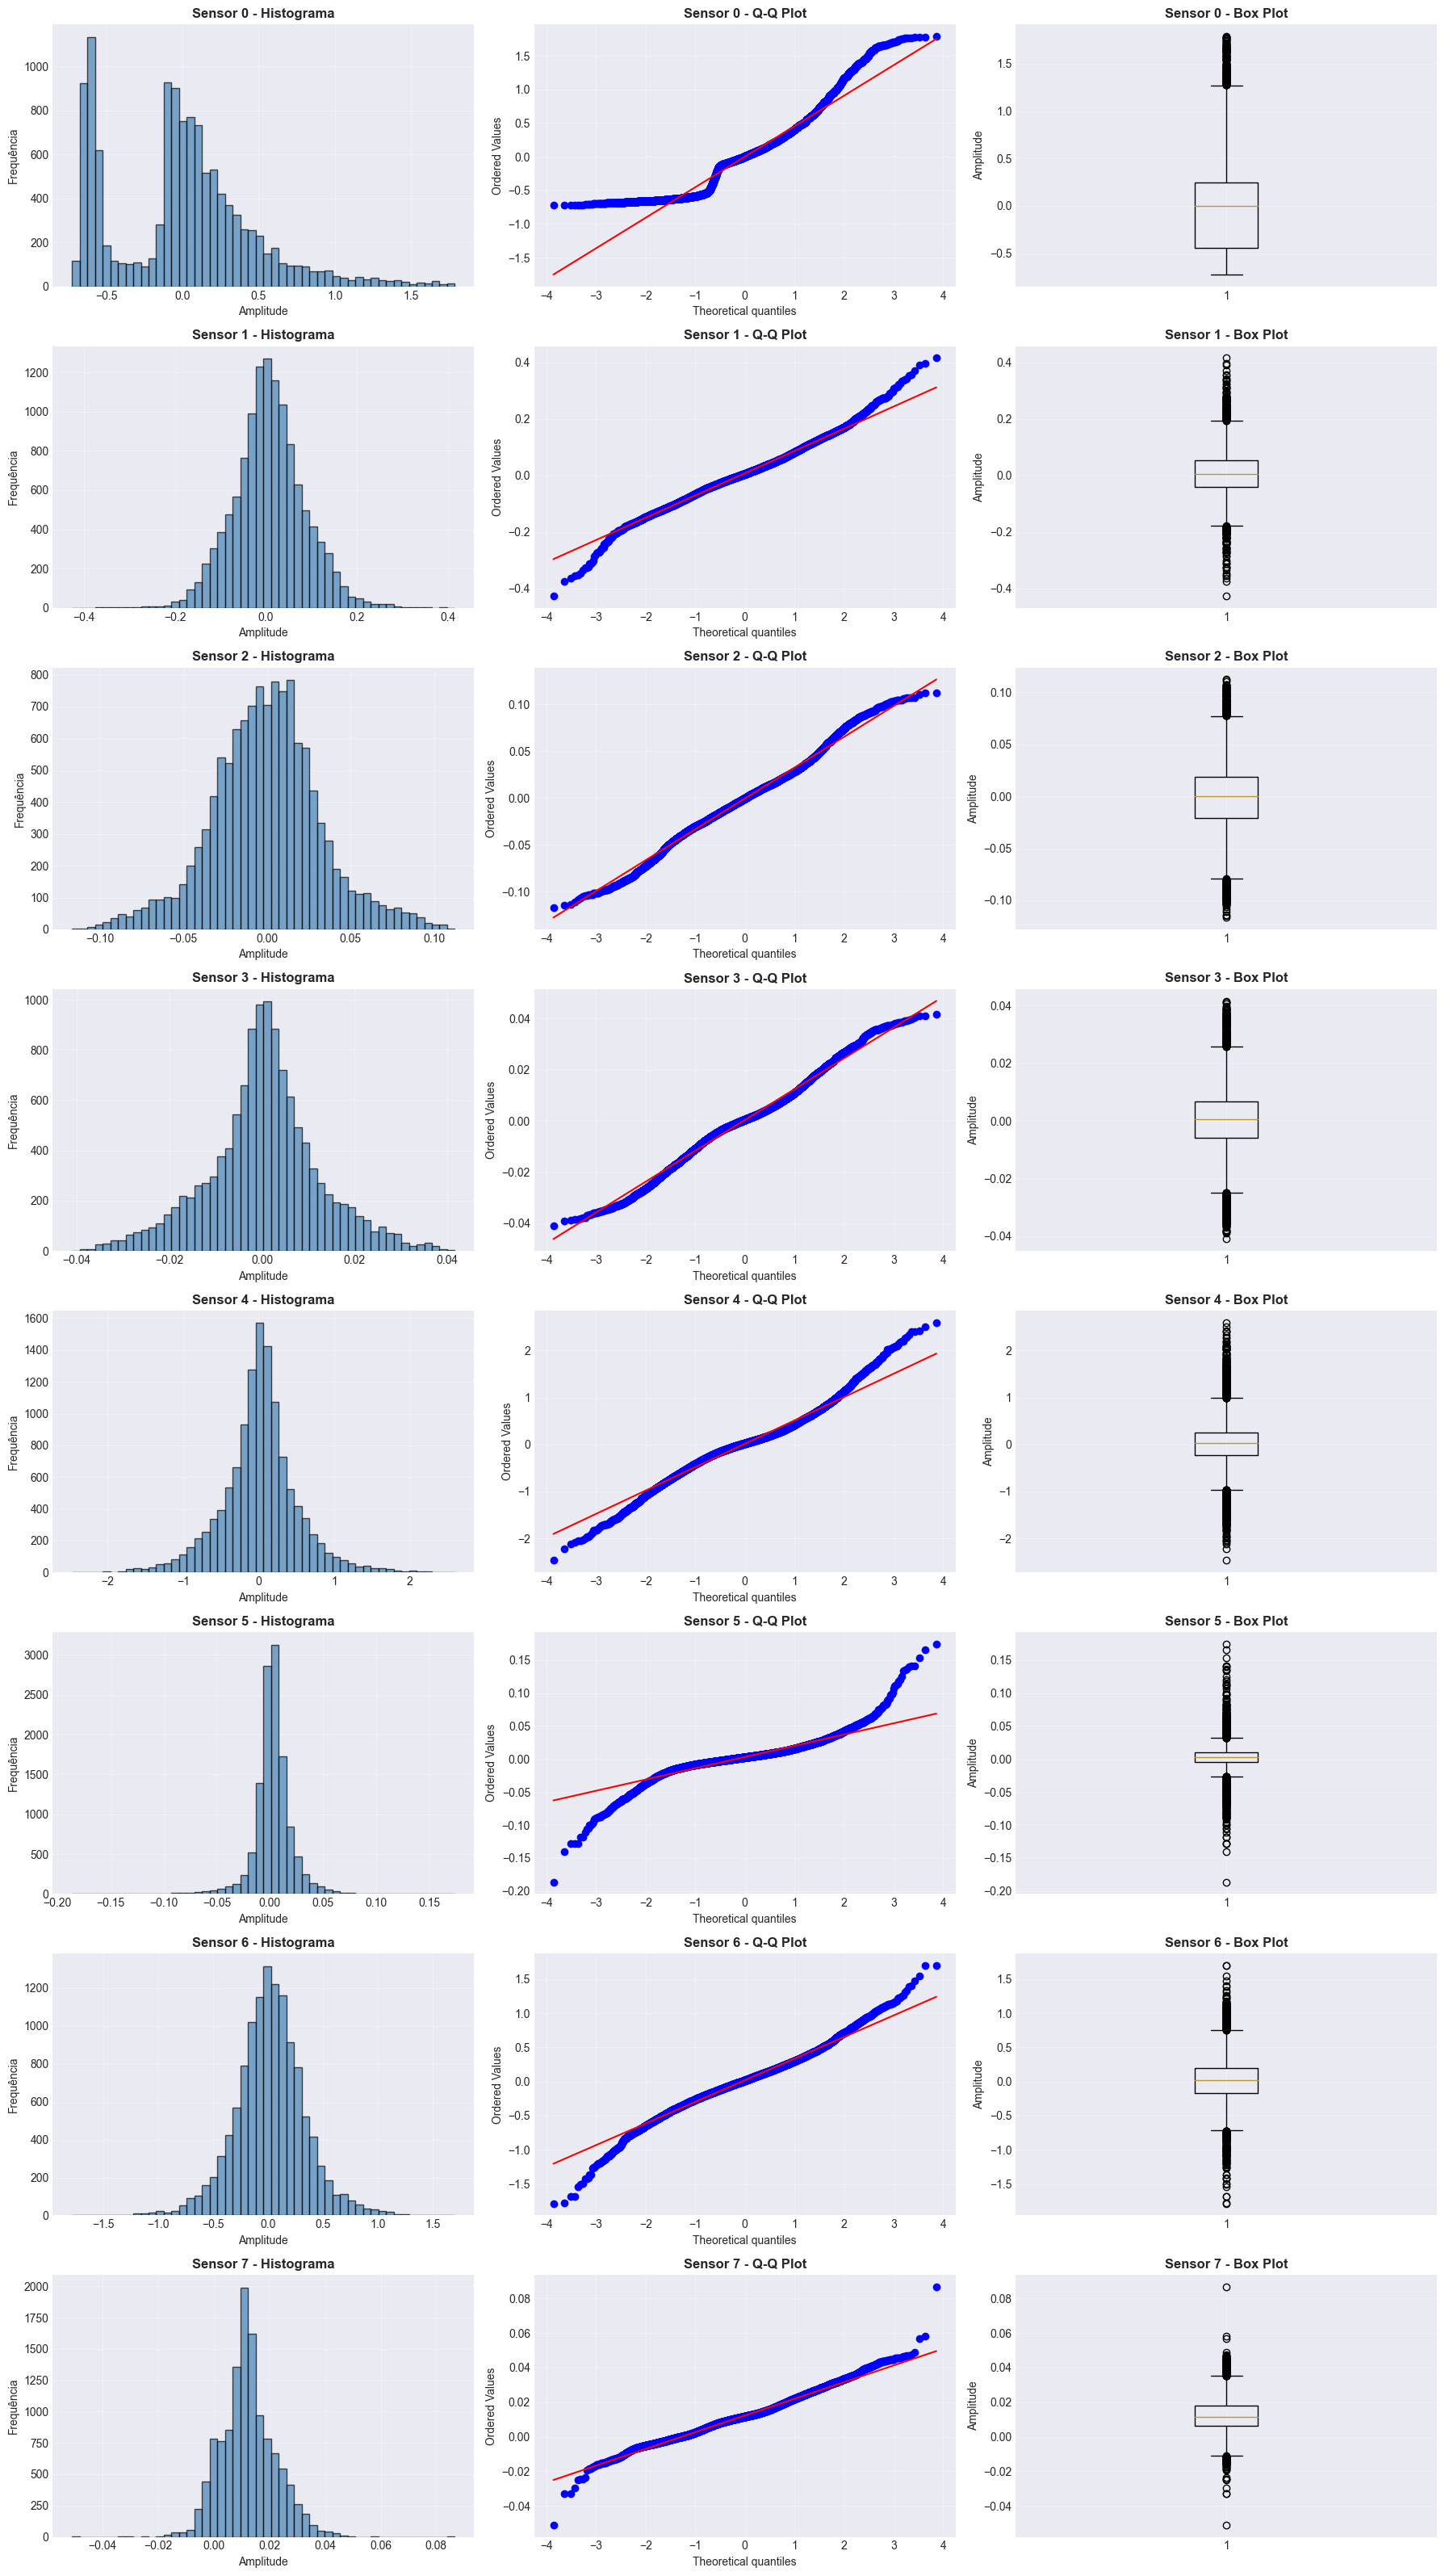

In [12]:
# Analise de distribuição para operação normal
analyze_distribution(data_normal, "Operação Normal")


Sensor 0:
  Média: -0.0000
  Desvio Padrão: 0.4494
  Assimetria (Skewness): 0.4910
  Curtose (Kurtosis): 0.3986
  Teste Shapiro-Wilk: estatística=0.9444, p-valor=7.4633e-40
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 1:
  Média: 0.0031
  Desvio Padrão: 0.0869
  Assimetria (Skewness): 0.1350
  Curtose (Kurtosis): -0.1053
  Teste Shapiro-Wilk: estatística=0.9964, p-valor=1.3949e-09
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 2:
  Média: 0.0003
  Desvio Padrão: 0.0685
  Assimetria (Skewness): 0.0210
  Curtose (Kurtosis): 1.5605
  Teste Shapiro-Wilk: estatística=0.9674, p-valor=3.3721e-32
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 3:
  Média: 0.0009
  Desvio Padrão: 0.0265
  Assimetria (Skewness): 0.0126
  Curtose (Kurtosis): 0.8361
  Teste Shapiro-Wilk: estatística=0.9906, p-valor=9.6385e-18
  → Distribuição NÃO NORMAL (p-valor < 0.05)

Sensor 4:
  Média: 0.0077
  Desvio Padrão: 0.0805
  Assimetria (Skewness): -0.3583
  Curtose (Kurtosis): 2.6267
  Teste Shapi

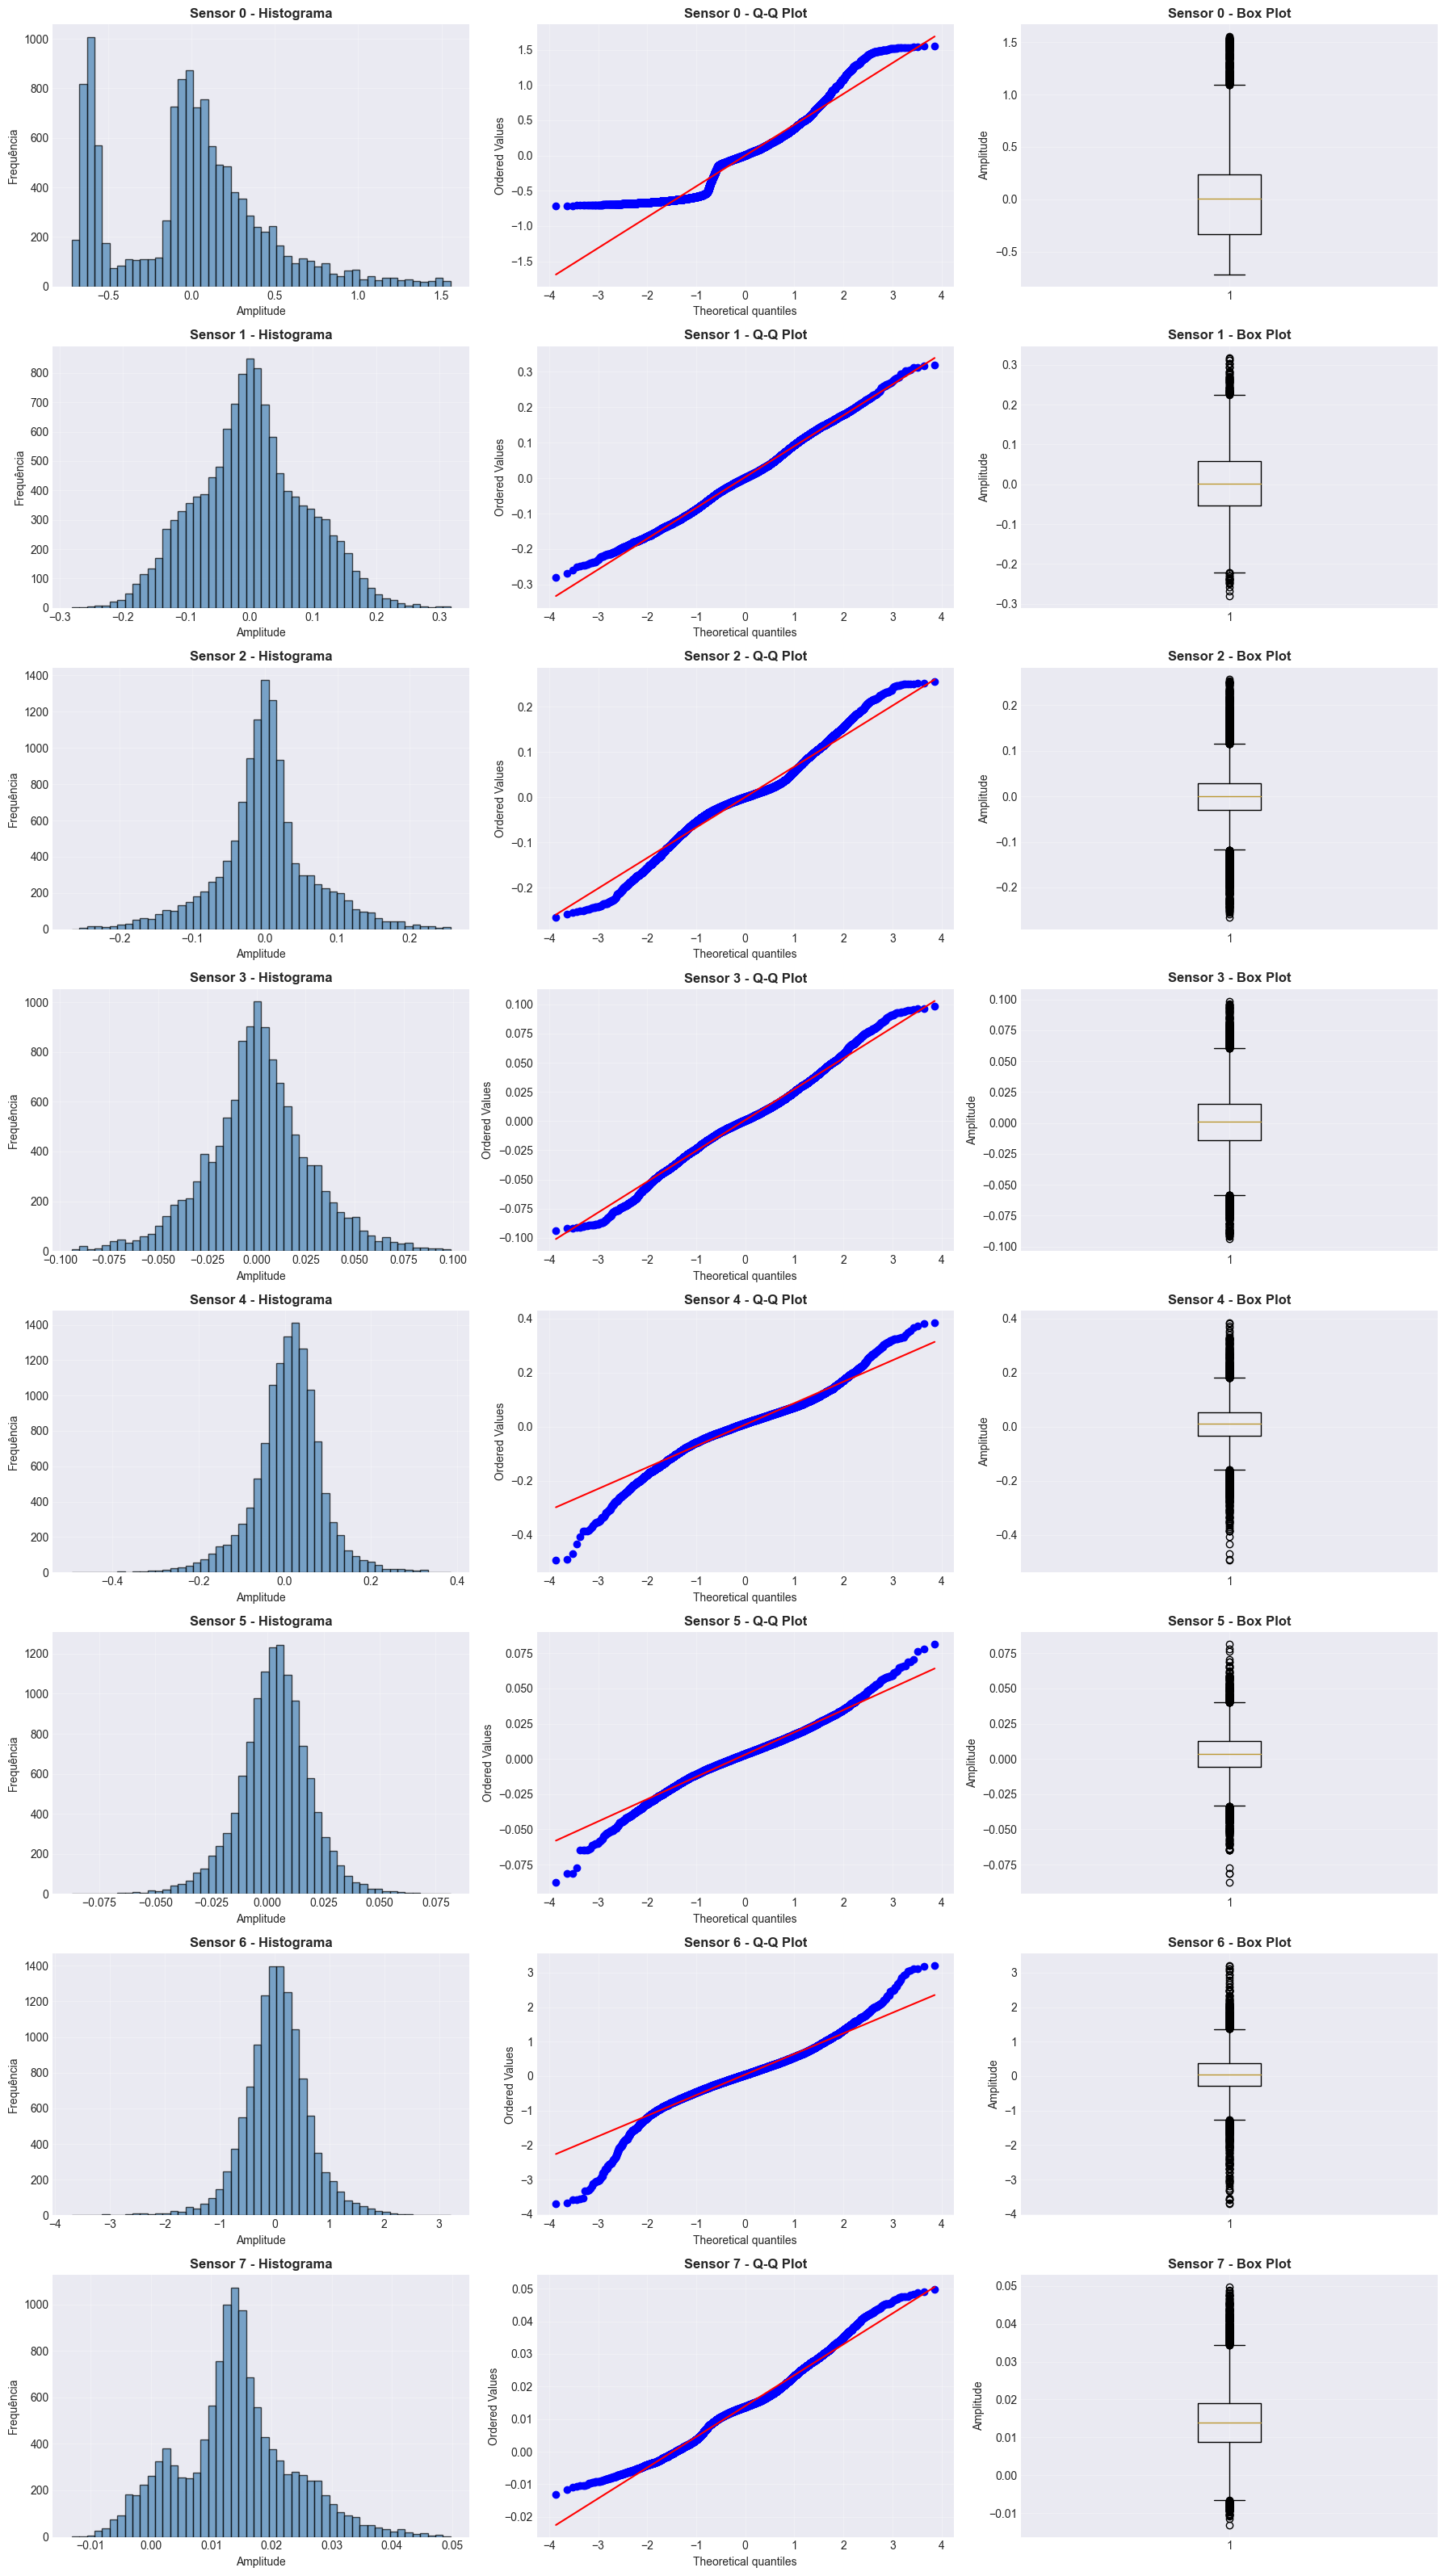

In [13]:
# Analise de distribuição para desbalanceamento 6g
analyze_distribution(data_6g, "Desbalanceamento 6g")

### 2.4 Análise de Autocorrelação
A autocorrelação indica se há dependência temporal nos dados. Isso é crucial para entender se os valores passados influenciam os valores futuros, o que afeta a escolha de modelos e técnicas de pré-processamento.

In [14]:
def analyze_autocorrelation(data, condition_name, lags=50, sample_size=2000):
    """
    Analisa a autocorrelação dos dados.
    
    Parâmetros:
    -----------
    data : pd.DataFrame
        DataFrame com os dados dos sensores
    condition_name : str
        Nome da condição
    lags : int
        Número de lags a considerar
    sample_size : int
        Tamanho da amostra para análise
    """
    num_sensors = data.shape[1]
    
    fig, axes = plt.subplots(num_sensors, 2, figsize=(15, 4 * num_sensors))
    
    if num_sensors == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_sensors):
        sensor_data = data.iloc[:sample_size, i].dropna()
        
        # ACF (Autocorrelation Function)
        plot_acf(sensor_data, lags=lags, ax=axes[i, 0], alpha=0.05)
        axes[i, 0].set_title(f'Sensor {i} - ACF (Autocorrelação)', fontweight='bold')
        axes[i, 0].set_xlabel('Lag')
        axes[i, 0].set_ylabel('Autocorrelação')
        axes[i, 0].grid(True, alpha=0.3)
        
        # PACF (Partial Autocorrelation Function)
        plot_pacf(sensor_data, lags=lags, ax=axes[i, 1], alpha=0.05)
        axes[i, 1].set_title(f'Sensor {i} - PACF (Autocorrelação Parcial)', fontweight='bold')
        axes[i, 1].set_xlabel('Lag')
        axes[i, 1].set_ylabel('Autocorrelação Parcial')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Calcular autocorrelação para os primeiros lags
        acf_values = acf(sensor_data, nlags=10)
        print(f"\nSensor {i}:")
        print(f"  Autocorrelação (lag 1): {acf_values[1]:.4f}")
        print(f"  Autocorrelação (lag 5): {acf_values[5]:.4f}")
        print(f"  Autocorrelação (lag 10): {acf_values[10]:.4f}")
    
    plt.tight_layout()
    plt.show()


Sensor 0:
  Autocorrelação (lag 1): -0.4277
  Autocorrelação (lag 5): -0.2260
  Autocorrelação (lag 10): -0.0494

Sensor 1:
  Autocorrelação (lag 1): -0.1817
  Autocorrelação (lag 5): -0.3185
  Autocorrelação (lag 10): 0.0324

Sensor 2:
  Autocorrelação (lag 1): -0.3375
  Autocorrelação (lag 5): -0.2329
  Autocorrelação (lag 10): 0.0180

Sensor 3:
  Autocorrelação (lag 1): -0.5721
  Autocorrelação (lag 5): 0.4831
  Autocorrelação (lag 10): 0.2267

Sensor 4:
  Autocorrelação (lag 1): 0.8161
  Autocorrelação (lag 5): 0.4224
  Autocorrelação (lag 10): 0.1887

Sensor 5:
  Autocorrelação (lag 1): 0.2388
  Autocorrelação (lag 5): -0.0931
  Autocorrelação (lag 10): 0.0290

Sensor 6:
  Autocorrelação (lag 1): 0.8799
  Autocorrelação (lag 5): 0.5616
  Autocorrelação (lag 10): 0.2363

Sensor 7:
  Autocorrelação (lag 1): -0.2430
  Autocorrelação (lag 5): -0.1700
  Autocorrelação (lag 10): 0.0038


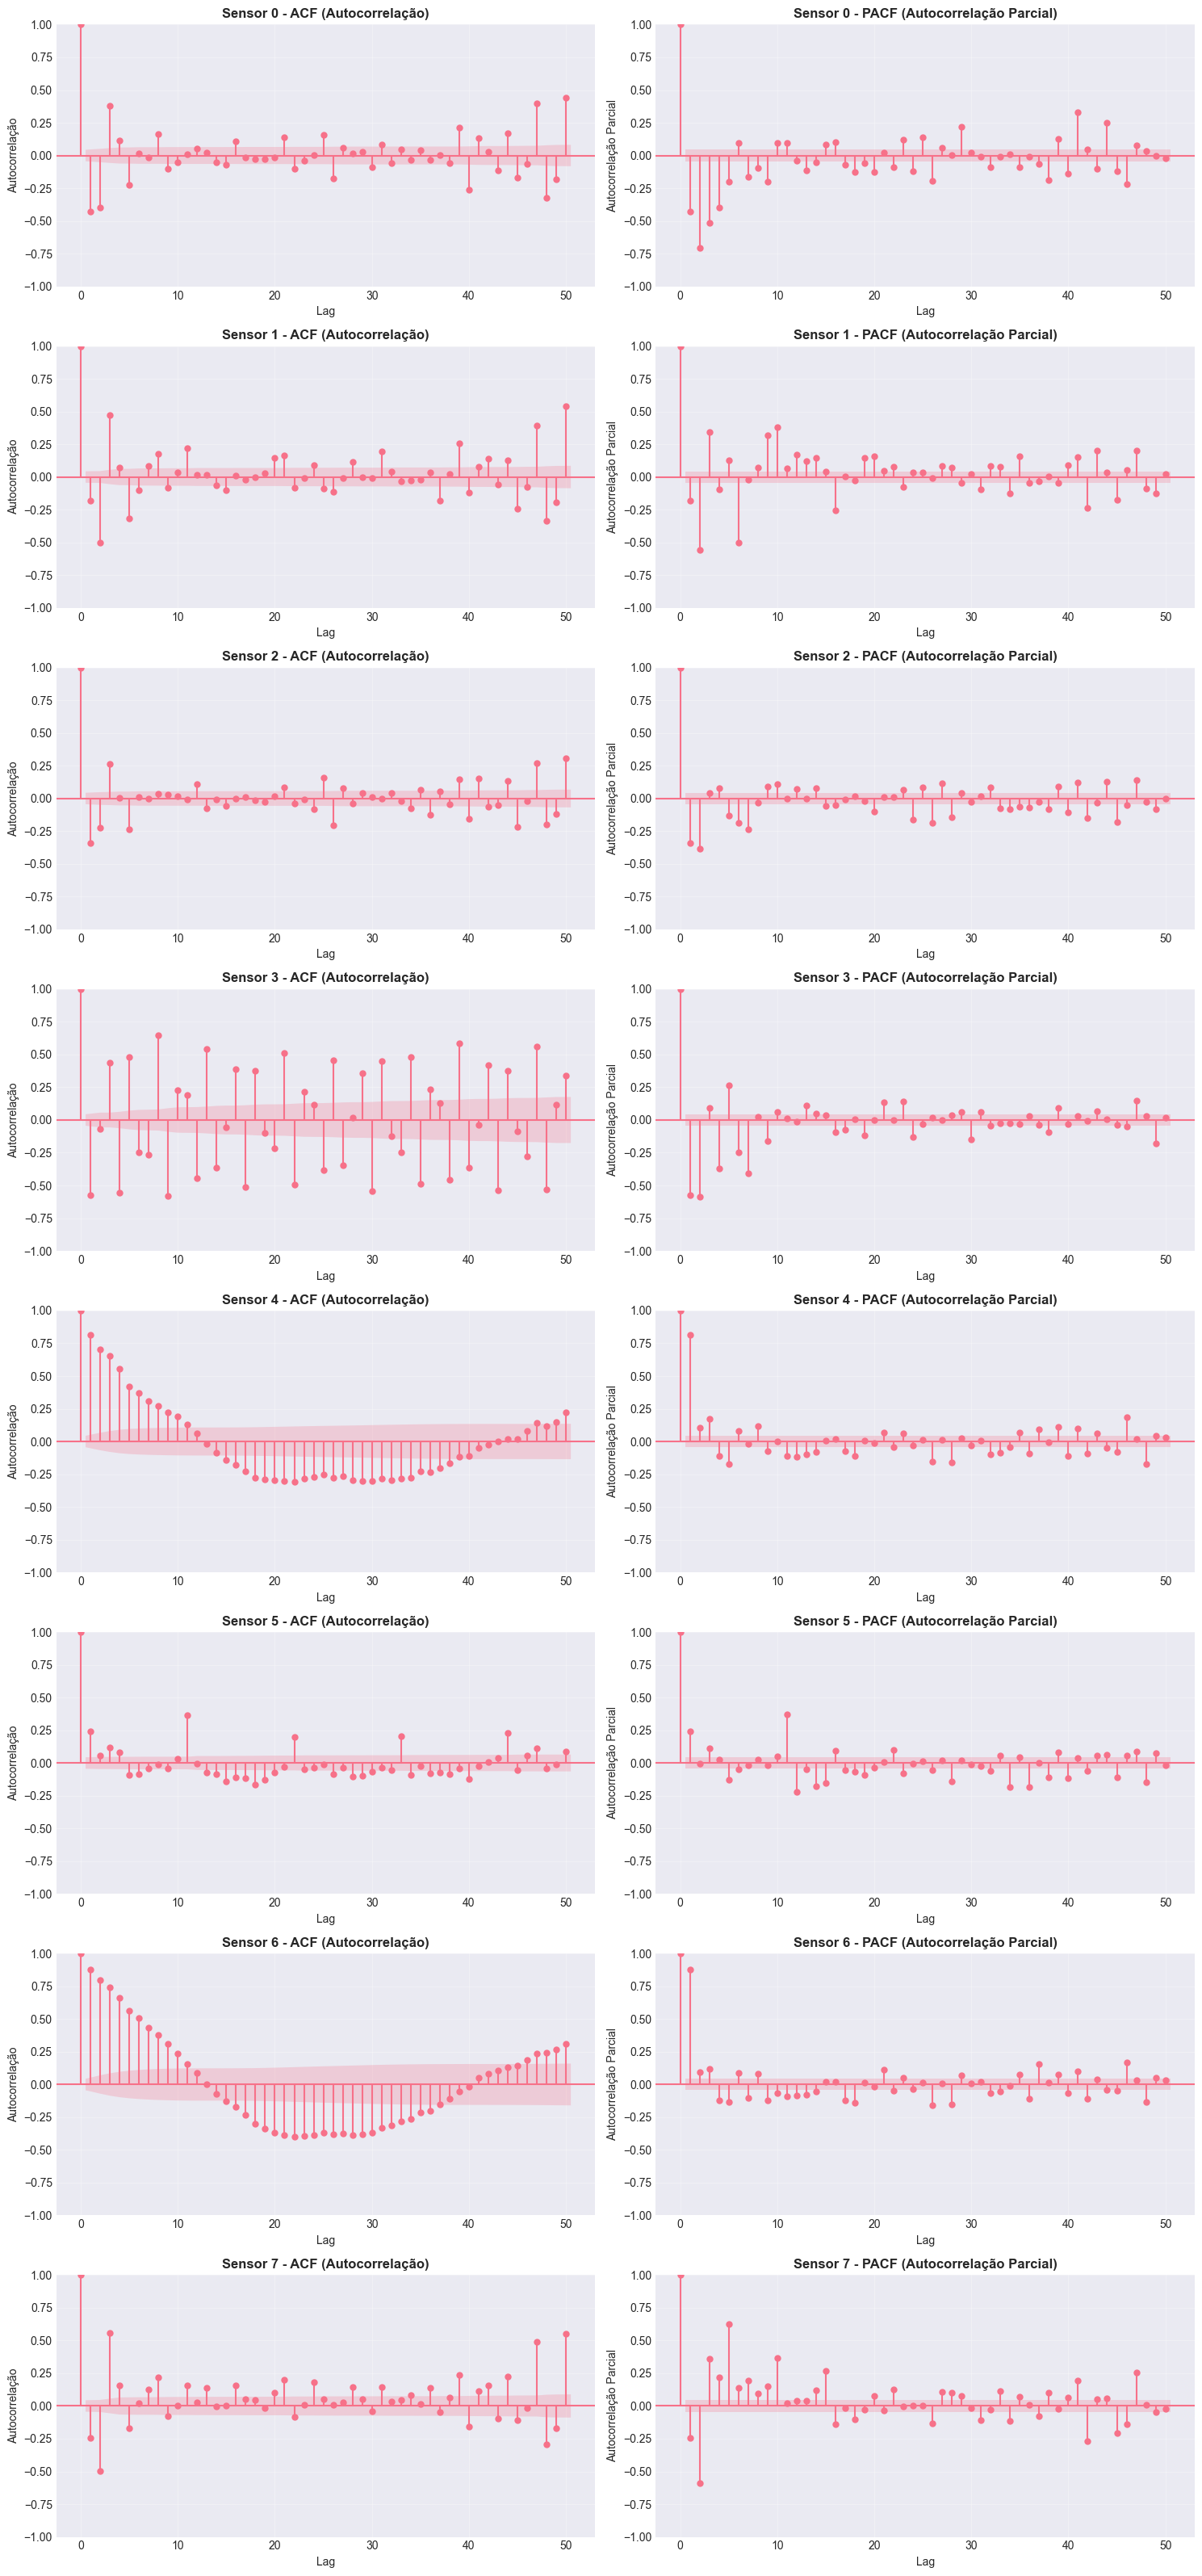

In [15]:
# Analisar autocorrelação para operação normal
analyze_autocorrelation(data_normal, "Operação Normal")


Sensor 0:
  Autocorrelação (lag 1): -0.4852
  Autocorrelação (lag 5): -0.1243
  Autocorrelação (lag 10): 0.1120

Sensor 1:
  Autocorrelação (lag 1): -0.3828
  Autocorrelação (lag 5): -0.1648
  Autocorrelação (lag 10): 0.1251

Sensor 2:
  Autocorrelação (lag 1): -0.4199
  Autocorrelação (lag 5): 0.0909
  Autocorrelação (lag 10): 0.1761

Sensor 3:
  Autocorrelação (lag 1): -0.7373
  Autocorrelação (lag 5): 0.7717
  Autocorrelação (lag 10): 0.5996

Sensor 4:
  Autocorrelação (lag 1): 0.4999
  Autocorrelação (lag 5): -0.0336
  Autocorrelação (lag 10): -0.0608

Sensor 5:
  Autocorrelação (lag 1): 0.4582
  Autocorrelação (lag 5): -0.0585
  Autocorrelação (lag 10): -0.0571

Sensor 6:
  Autocorrelação (lag 1): 0.8520
  Autocorrelação (lag 5): 0.5106
  Autocorrelação (lag 10): 0.2017

Sensor 7:
  Autocorrelação (lag 1): -0.4028
  Autocorrelação (lag 5): -0.1986
  Autocorrelação (lag 10): 0.2157


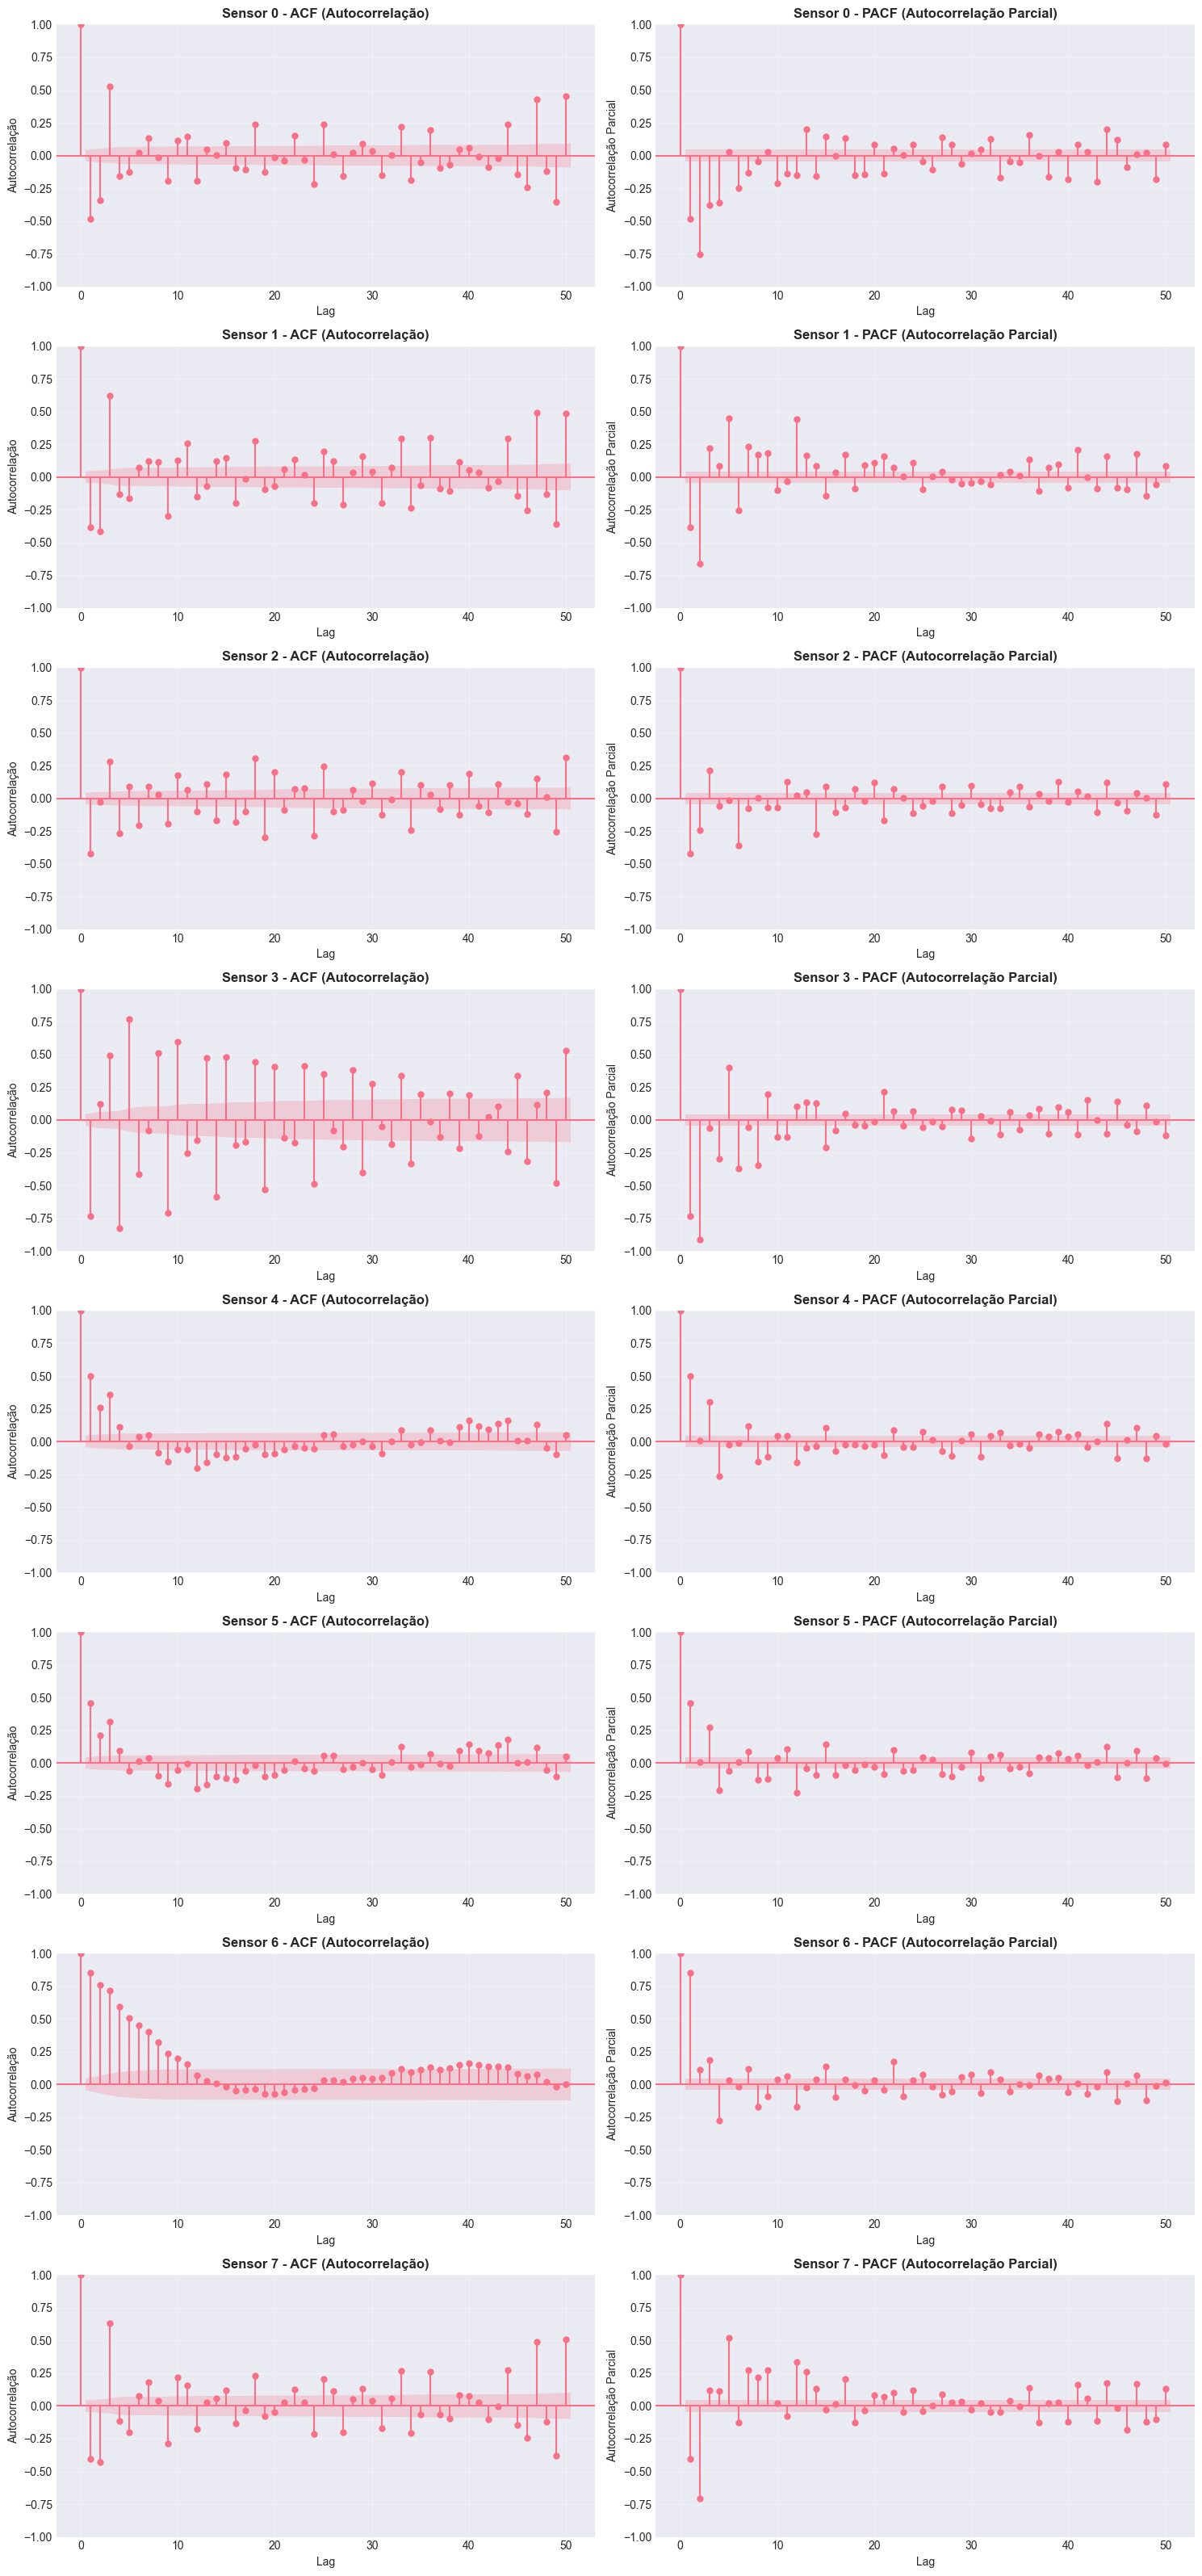

In [16]:
# Analisar autocorrelação para desbalanceamento 6g
analyze_autocorrelation(data_6g, "Desbalanceamento 6g")

### 2.5 Teste de Estacionaridade
Verificar se a série temporal é estacionária (média e variância constantes ao longo do tempo) é fundamental para muitos modelos de séries temporais.

In [17]:
def test_stationarity(data, condition_name, sample_size=2000):
    """
    Testa a estacionaridade dos dados usando o teste ADF.
    
    Parâmetros:
    -----------
    data : pd.DataFrame
        DataFrame com os dados dos sensores
    condition_name : str
        Nome da condição
    sample_size : int
        Tamanho da amostra para teste
    """
    num_sensors = data.shape[1]
    
    print(f"\nTESTE DE ESTACIONARIDADE (ADF) - {condition_name}")
    print("=" * 80)
    print("H0: A série possui raiz unitária (NÃO estacionária)")
    print("H1: A série NÃO possui raiz unitária (estacionária)")
    print("Critério: p-valor < 0.05 → Rejeitar H0 (série é estacionária)")
    print("=" * 80)
    
    for i in range(num_sensors):
        sensor_data = data.iloc[:sample_size, i].dropna()
        
        # Teste ADF
        result = adfuller(sensor_data, autolag='AIC')
        
        print(f"\nSensor {i}:")
        print(f"  Estatística ADF: {result[0]:.4f}")
        print(f"  P-valor: {result[1]:.4e}")
        print(f"  Lags usados: {result[2]}")
        print(f"  Número de observações: {result[3]}")
        print(f"  Valores críticos:")
        for key, value in result[4].items():
            print(f"    {key}: {value:.4f}")
        
        if result[1] < 0.05:
            print(f"  → Série ESTACIONÁRIA (p-valor < 0.05)")
        else:
            print(f"  → Série NÃO ESTACIONÁRIA (p-valor >= 0.05)")

# Testar estacionaridade para todas as condições
for name, df in datasets.items():
    test_stationarity(df, name)


TESTE DE ESTACIONARIDADE (ADF) - Normal
H0: A série possui raiz unitária (NÃO estacionária)
H1: A série NÃO possui raiz unitária (estacionária)
Critério: p-valor < 0.05 → Rejeitar H0 (série é estacionária)

Sensor 0:
  Estatística ADF: -12.6774
  P-valor: 1.2076e-23
  Lags usados: 26
  Número de observações: 1973
  Valores críticos:
    1%: -3.4337
    5%: -2.8630
    10%: -2.5676
  → Série ESTACIONÁRIA (p-valor < 0.05)

Sensor 1:
  Estatística ADF: -3.5121
  P-valor: 7.6812e-03
  Lags usados: 26
  Número de observações: 1973
  Valores críticos:
    1%: -3.4337
    5%: -2.8630
    10%: -2.5676
  → Série ESTACIONÁRIA (p-valor < 0.05)

Sensor 2:
  Estatística ADF: -9.8784
  P-valor: 3.8265e-17
  Lags usados: 26
  Número de observações: 1973
  Valores críticos:
    1%: -3.4337
    5%: -2.8630
    10%: -2.5676
  → Série ESTACIONÁRIA (p-valor < 0.05)

Sensor 3:
  Estatística ADF: -10.1791
  P-valor: 6.7681e-18
  Lags usados: 24
  Número de observações: 1975
  Valores críticos:
    1%: -3.4

### 2.6 Análise de Frequência (FFT)
A análise de frequência usando a Transformada Rápida de Fourier (FFT) permite identificar componentes periódicas nos dados. Isso é especialmente importante para dados de vibração mecânica, onde diferentes falhas podem manifestar-se em diferentes frequências.

Após o downsampling, a taxa de amostragem efetiva é de ~10 Hz (50.000 Hz / 5.000).

In [18]:
def analyze_frequency(data, condition_name, sampling_rate=10, sample_size=2000):
    """
    Analisa o espectro de frequência dos dados usando FFT.
    
    Parâmetros:
    -----------
    data : pd.DataFrame
        DataFrame com os dados dos sensores
    condition_name : str
        Nome da condição
    sampling_rate : float
        Taxa de amostragem efetiva em Hz após downsampling (padrão: 10 Hz)
    sample_size : int
        Tamanho da amostra para análise
    """
    num_sensors = data.shape[1]
    
    fig, axes = plt.subplots(num_sensors, 2, figsize=(18, 4 * num_sensors))
    
    if num_sensors == 1:
        axes = axes.reshape(1, -1)
    
    print(f"\nANÁLISE DE FREQUÊNCIA (FFT) - {condition_name}")
    print("=" * 80)
    print(f"Taxa de amostragem efetiva: {sampling_rate} Hz")
    print(f"Frequência máxima detectável (Nyquist): {sampling_rate/2} Hz")
    print("=" * 80)
    
    for i in range(num_sensors):
        sensor_data = data.iloc[:sample_size, i].dropna().values
        
        # Calcular FFT
        N = len(sensor_data)
        yf = fft(sensor_data)
        xf = fftfreq(N, 1 / sampling_rate)[:N//2]
        
        # Magnitude do espectro
        magnitude = 2.0/N * np.abs(yf[0:N//2])
        
        # Plot do espectro completo
        axes[i, 0].plot(xf, magnitude, linewidth=0.8)
        axes[i, 0].set_title(f'Sensor {i} - Espectro de Frequência (Completo)', fontweight='bold')
        axes[i, 0].set_xlabel('Frequência (Hz)')
        axes[i, 0].set_ylabel('Magnitude')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_xlim([0, sampling_rate/2])
        
        # Plot do espectro em escala logarítmica (melhor visualização)
        axes[i, 1].semilogy(xf, magnitude + 1e-10, linewidth=0.8)  # +1e-10 para evitar log(0)
        axes[i, 1].set_title(f'Sensor {i} - Espectro de Frequência (Escala Log)', fontweight='bold')
        axes[i, 1].set_xlabel('Frequência (Hz)')
        axes[i, 1].set_ylabel('Magnitude (log)')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].set_xlim([0, sampling_rate/2])
        
        # Encontrar frequências dominantes
        top_indices = np.argsort(magnitude)[-5:][::-1]
        top_freqs = xf[top_indices]
        top_mags = magnitude[top_indices]
        
        print(f"\nSensor {i}:")
        print(f"  Top 5 Frequências Dominantes:")
        for j, (freq, mag) in enumerate(zip(top_freqs, top_mags), 1):
            print(f"    {j}. {freq:.4f} Hz (magnitude: {mag:.4f})")
    
    plt.tight_layout()
    plt.show()


ANÁLISE DE FREQUÊNCIA (FFT) - Operação Normal
Taxa de amostragem efetiva: 10 Hz
Frequência máxima detectável (Nyquist): 5.0 Hz

Sensor 0:
  Top 5 Frequências Dominantes:
    1. 4.8450 Hz (magnitude: 0.1333)
    2. 4.8500 Hz (magnitude: 0.1321)
    3. 2.9700 Hz (magnitude: 0.1298)
    4. 2.8150 Hz (magnitude: 0.1272)
    5. 2.9750 Hz (magnitude: 0.1268)

Sensor 1:
  Top 5 Frequências Dominantes:
    1. 0.0000 Hz (magnitude: 0.0292)
    2. 2.8150 Hz (magnitude: 0.0251)
    3. 2.8200 Hz (magnitude: 0.0251)
    4. 2.8250 Hz (magnitude: 0.0249)
    5. 2.5700 Hz (magnitude: 0.0245)

Sensor 2:
  Top 5 Frequências Dominantes:
    1. 2.9800 Hz (magnitude: 0.0037)
    2. 4.8550 Hz (magnitude: 0.0036)
    3. 2.8250 Hz (magnitude: 0.0031)
    4. 3.4450 Hz (magnitude: 0.0031)
    5. 3.3700 Hz (magnitude: 0.0030)

Sensor 3:
  Top 5 Frequências Dominantes:
    1. 3.8400 Hz (magnitude: 0.0020)
    2. 3.8350 Hz (magnitude: 0.0020)
    3. 3.8300 Hz (magnitude: 0.0019)
    4. 3.8450 Hz (magnitude: 0.001

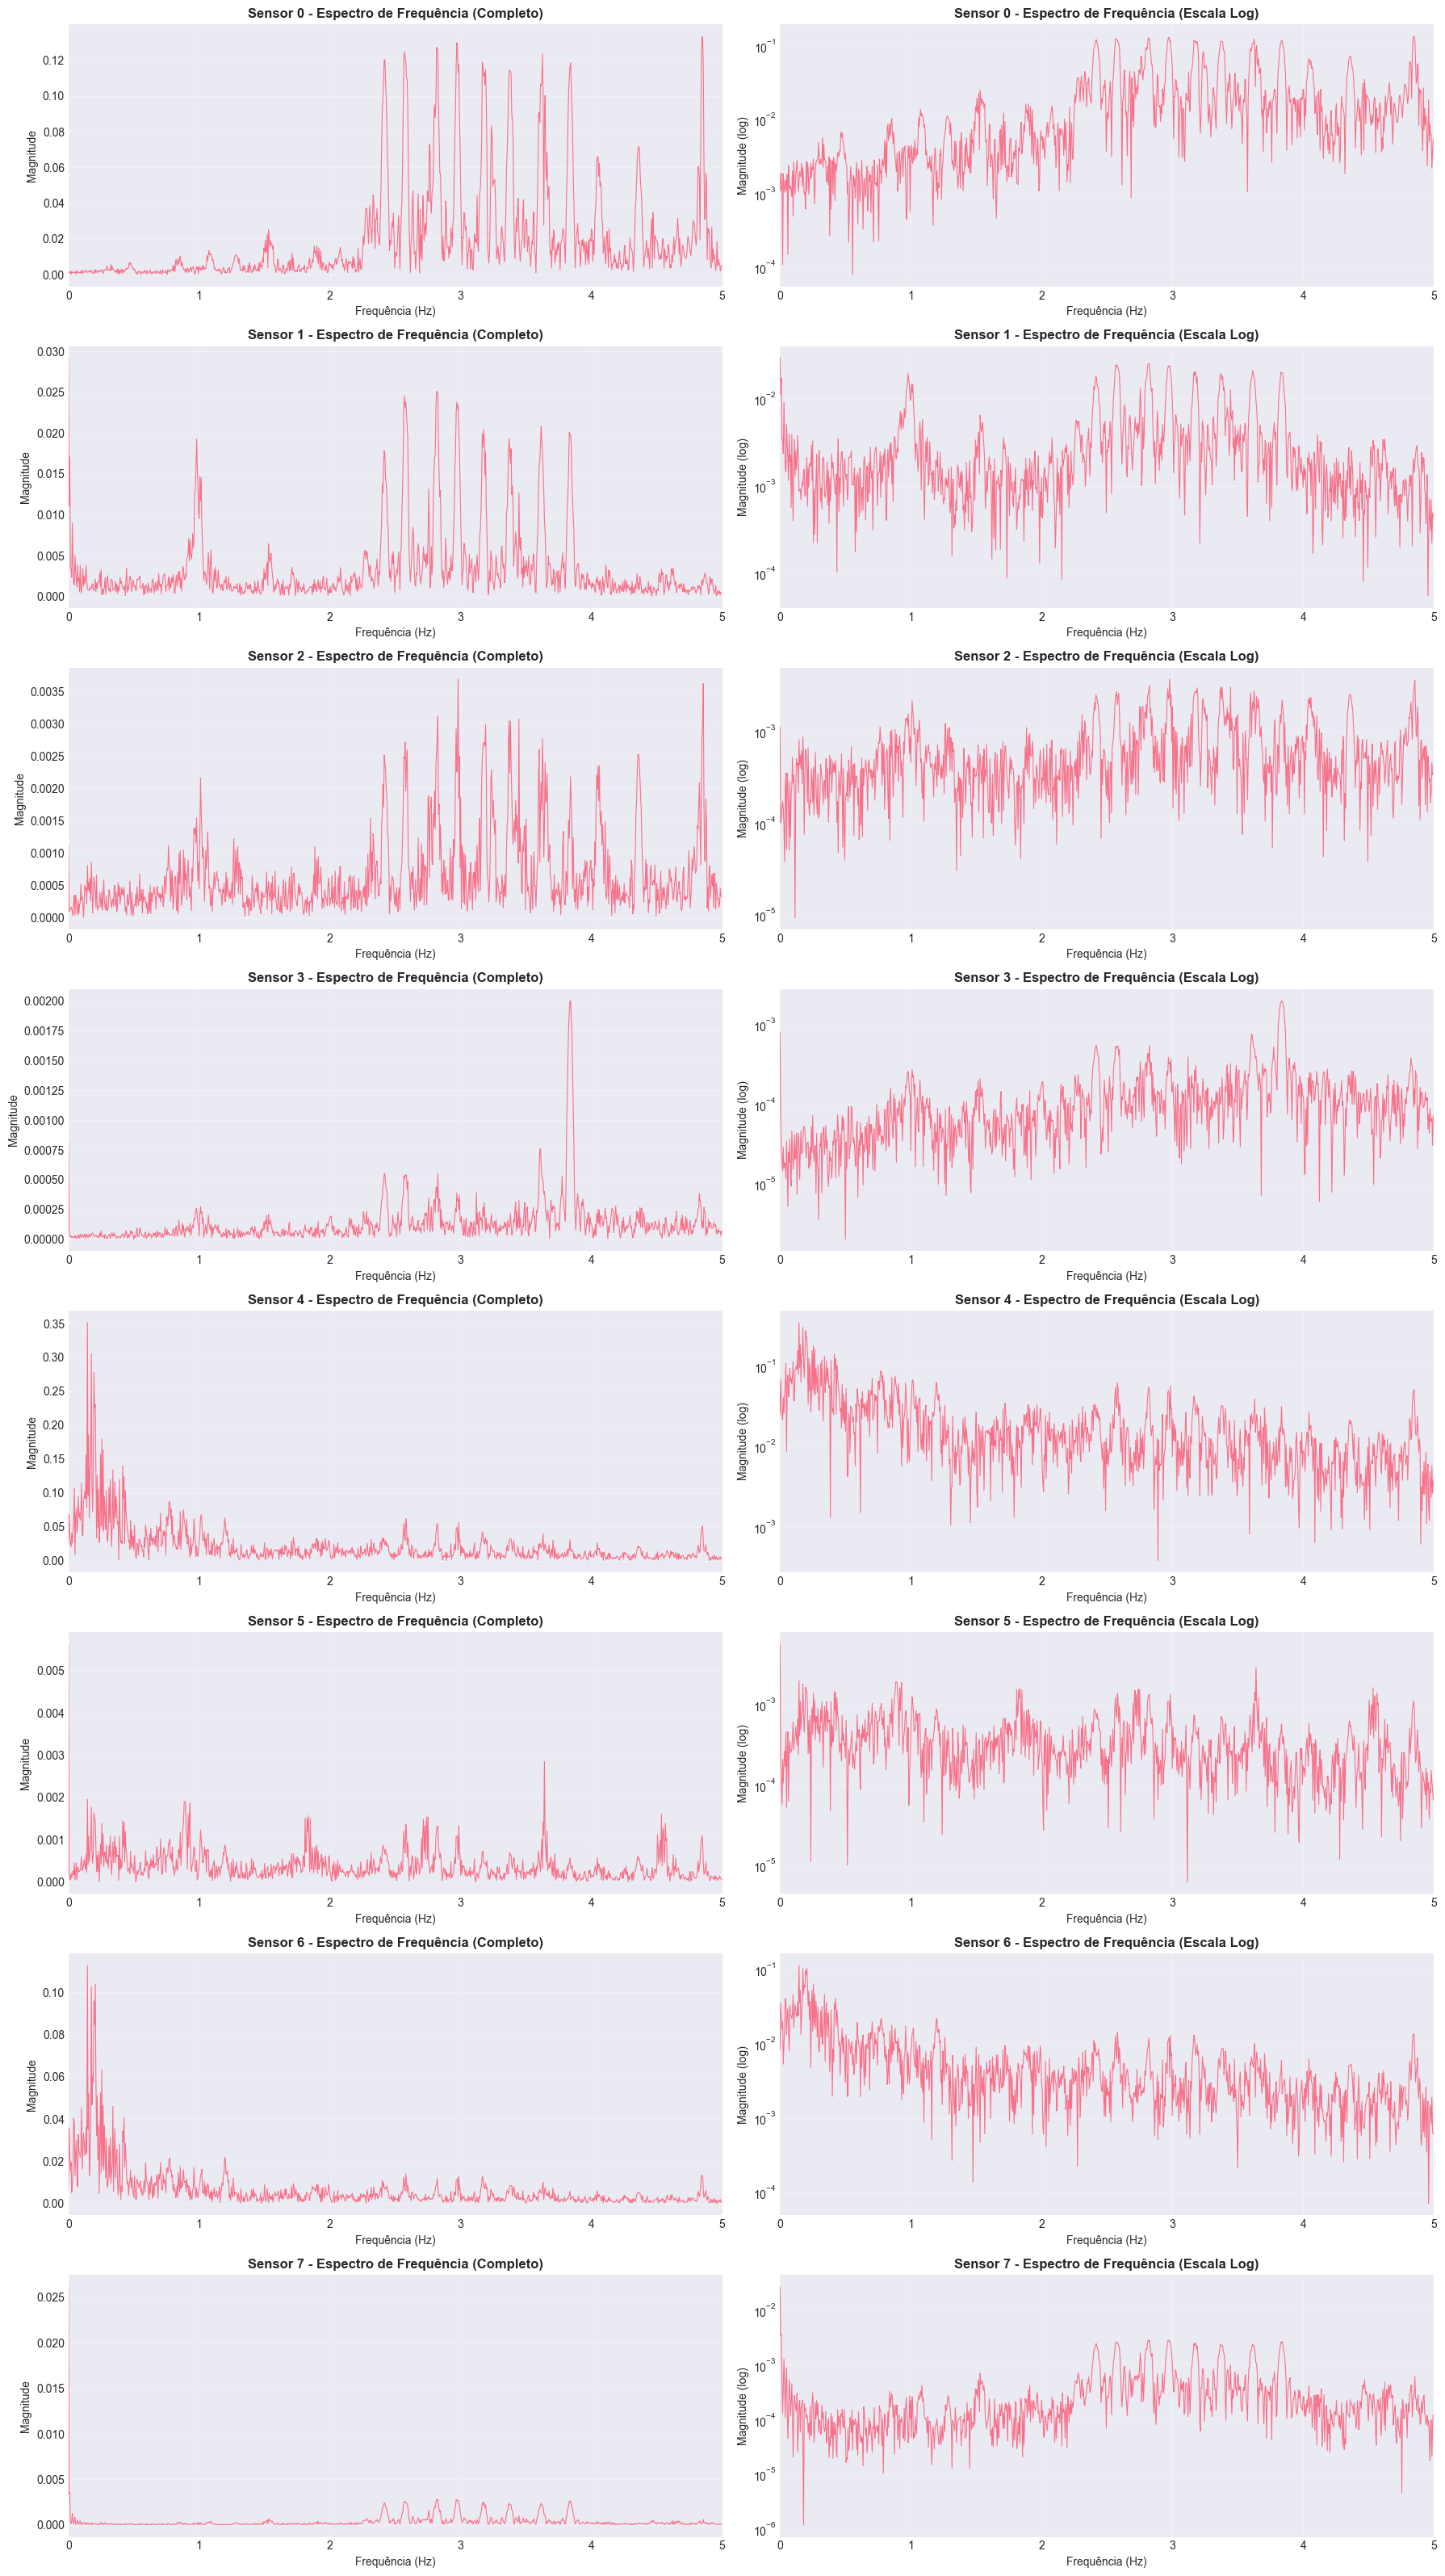

In [19]:
# Analisar frequência para operação normal
analyze_frequency(data_normal, "Operação Normal")


ANÁLISE DE FREQUÊNCIA (FFT) - Desbalanceamento 6g
Taxa de amostragem efetiva: 10 Hz
Frequência máxima detectável (Nyquist): 5.0 Hz

Sensor 0:
  Top 5 Frequências Dominantes:
    1. 3.9850 Hz (magnitude: 0.1590)
    2. 2.8000 Hz (magnitude: 0.1575)
    3. 2.7900 Hz (magnitude: 0.1542)
    4. 3.6000 Hz (magnitude: 0.1404)
    5. 3.9700 Hz (magnitude: 0.1383)

Sensor 1:
  Top 5 Frequências Dominantes:
    1. 2.7950 Hz (magnitude: 0.0291)
    2. 2.8000 Hz (magnitude: 0.0260)
    3. 2.7900 Hz (magnitude: 0.0240)
    4. 3.6100 Hz (magnitude: 0.0230)
    5. 2.7300 Hz (magnitude: 0.0230)

Sensor 2:
  Top 5 Frequências Dominantes:
    1. 3.9750 Hz (magnitude: 0.0055)
    2. 3.9900 Hz (magnitude: 0.0049)
    3. 3.9600 Hz (magnitude: 0.0044)
    4. 3.9650 Hz (magnitude: 0.0044)
    5. 3.9800 Hz (magnitude: 0.0041)

Sensor 3:
  Top 5 Frequências Dominantes:
    1. 3.9700 Hz (magnitude: 0.0094)
    2. 3.9750 Hz (magnitude: 0.0093)
    3. 3.9800 Hz (magnitude: 0.0090)
    4. 3.9650 Hz (magnitude: 0

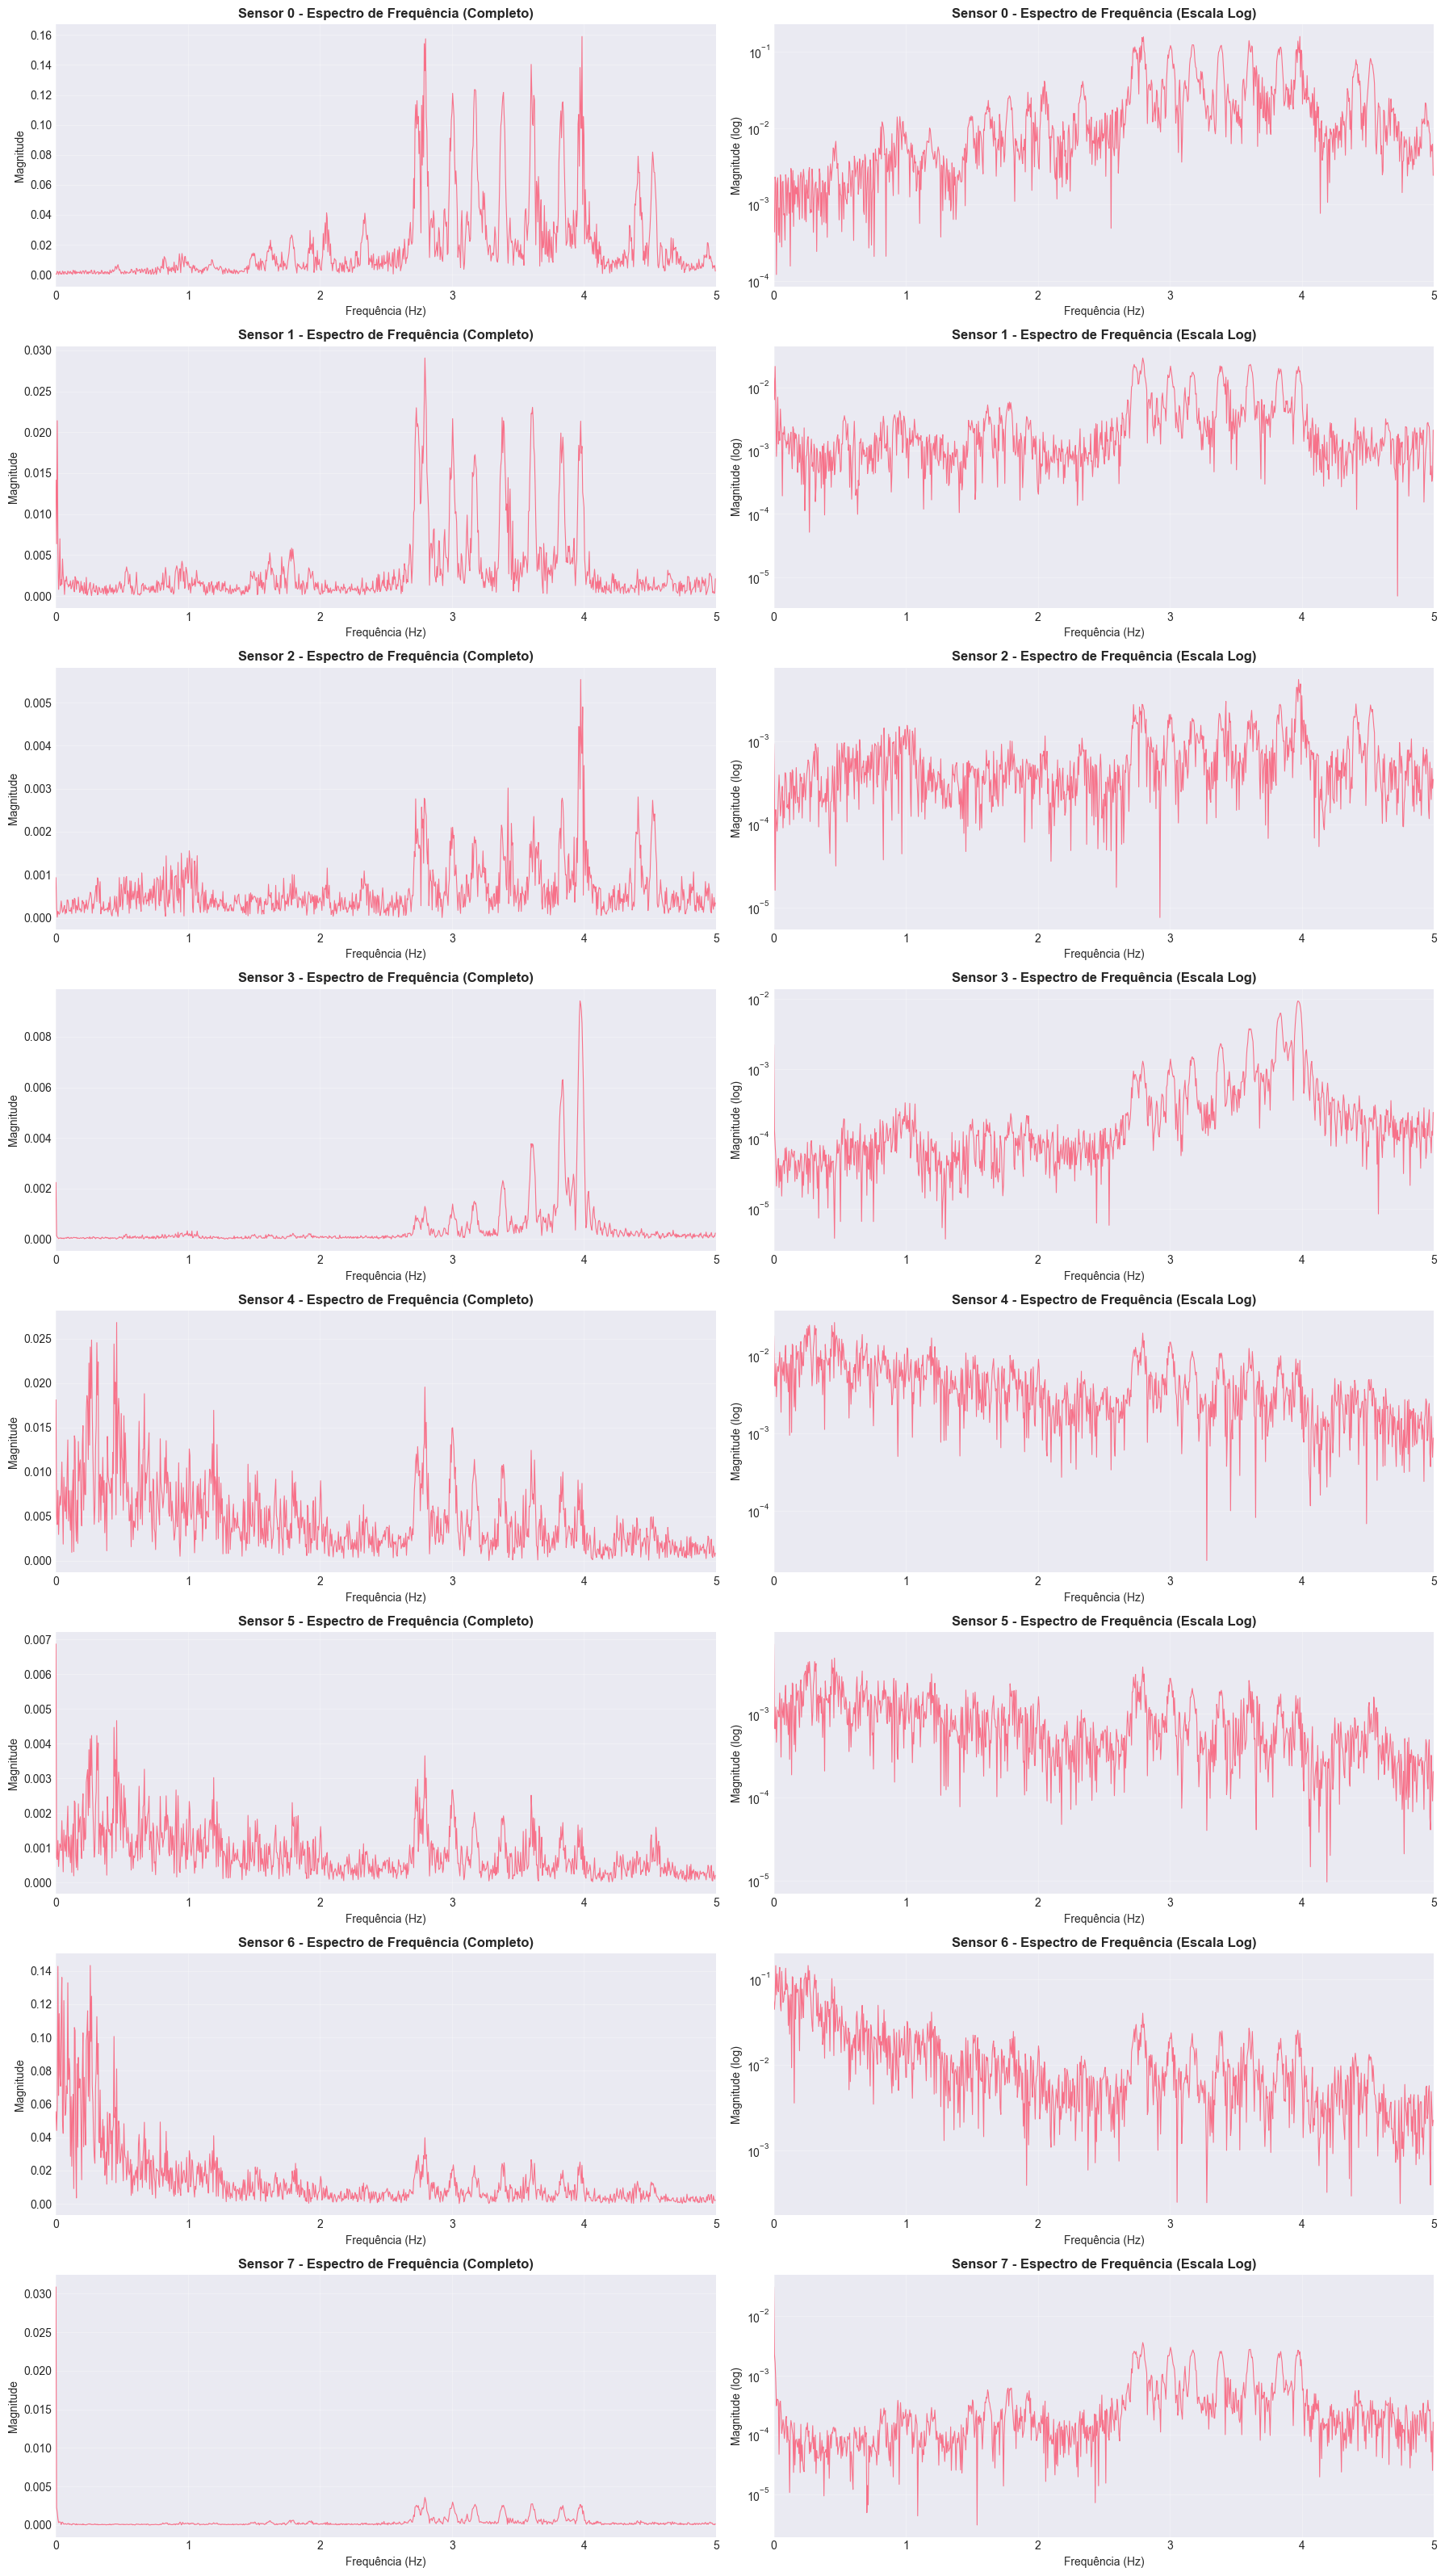

In [20]:
# Analisar frequência para desbalanceamento 6g
analyze_frequency(data_6g, "Desbalanceamento 6g")

## 3. Pré-Processamento dos dados.


### 3.1 Criação de Labels (Target)

Precisa-se categorizar cada condição de operação para classificação supervisionada.

### **Esquema de Categorização:**

- **Classe 0:** Normal (operação sem falha)
- **Classe 1:** Desbalanceamento 6g
- **Classe 2:** Desbalanceamento 10g
- **Classe 3:** Desbalanceamento 15g
- **Classe 4:** Desbalanceamento 20g
- **Classe 5:** Desbalanceamento 25g
- **Classe 6:** Desbalanceamento 30g
- **Classe 7:** Desbalanceamento 35g

In [21]:
y_normal = pd.DataFrame(np.zeros(len(data_normal), dtype=int), columns=['target'])
y_6g = pd.DataFrame(np.ones(len(data_6g), dtype=int), columns=['target'])
y_10g = pd.DataFrame(np.full(len(data_10g), 2, dtype=int), columns=['target'])
y_15g = pd.DataFrame(np.full(len(data_15g), 3, dtype=int), columns=['target'])
y_20g = pd.DataFrame(np.full(len(data_20g), 4, dtype=int), columns=['target'])
y_25g = pd.DataFrame(np.full(len(data_25g), 5, dtype=int), columns=['target'])
y_30g = pd.DataFrame(np.full(len(data_30g), 6, dtype=int), columns=['target'])
y_35g = pd.DataFrame(np.full(len(data_35g), 7, dtype=int), columns=['target'])

print(f"  - Normal (Classe 0): {len(y_normal)} amostras")
print(f"  - 6g (Classe 1): {len(y_6g)} amostras")
print(f"  - 10g (Classe 2): {len(y_10g)} amostras")
print(f"  - 15g (Classe 3): {len(y_15g)} amostras")
print(f"  - 20g (Classe 4): {len(y_20g)} amostras")
print(f"  - 25g (Classe 5): {len(y_25g)} amostras")
print(f"  - 30g (Classe 6): {len(y_30g)} amostras")
print(f"  - 35g (Classe 7): {len(y_35g)} amostras")

  - Normal (Classe 0): 12250 amostras
  - 6g (Classe 1): 12250 amostras
  - 10g (Classe 2): 12000 amostras
  - 15g (Classe 3): 12000 amostras
  - 20g (Classe 4): 12250 amostras
  - 25g (Classe 5): 11750 amostras
  - 30g (Classe 6): 11750 amostras
  - 35g (Classe 7): 11250 amostras


### 3.2 Concatenação dos Dados

Unir todos os dados em um único dataset facilita o processamento e garante que a padronização seja aplicada de forma consistente.

In [22]:
X = pd.concat([
    data_normal,
    data_6g,
    data_10g,
    data_15g,
    data_20g,
    data_25g,
    data_30g,
    data_35g
], ignore_index=True)

y = pd.concat([
    y_normal,
    y_6g,
    y_10g,
    y_15g,
    y_20g,
    y_25g,
    y_30g,
    y_35g
], ignore_index=True)

print(f"  - Shape de X (features): {X.shape}")
print(f"  - Shape de y (target): {y.shape}")
print(f"  - Total de amostras: {len(X):,}")
print(f"  - Número de sensores: {X.shape[1]}")

  - Shape de X (features): (95500, 8)
  - Shape de y (target): (95500, 1)
  - Total de amostras: 95,500
  - Número de sensores: 8


In [23]:
dataset_completo = X.copy()
dataset_completo['target'] = y.values
display(dataset_completo.head(20))
print(f"\nShape: {dataset_completo.shape}")


0         1         2         3         4         5         6  \
0   1.203398 -0.122523 -0.000420 -0.004745 -0.042759  0.008953 -0.058694   
1  -0.584449 -0.176627 -0.030719 -0.002918  0.030208  0.001675 -0.057903   
2  -0.551016  0.063121  0.009094  0.000020  0.061094 -0.001865 -0.073677   
3  -0.501559  0.160005 -0.007349  0.006786  0.343338  0.007399  0.038513   
4   1.645809  0.005535  0.033461 -0.000279  0.675661  0.011043  0.175079   
5  -0.560066 -0.146686 -0.030888 -0.003870 -0.164752 -0.007218  0.033740   
6  -0.538960  0.029259  0.007218  0.000160  0.211077  0.000736  0.080827   
7  -0.518464  0.165359  0.021424  0.006261 -0.060573 -0.000568  0.019931   
8   1.670614 -0.070595  0.004285 -0.003615 -0.065228  0.012490  0.040577   
9  -0.578189 -0.204702 -0.037910 -0.004406 -0.871046 -0.011055 -0.161673   
10 -0.525711  0.052071  0.010699  0.001829 -0.942154 -0.013074 -0.255123   
11 -0.496895  0.139639  0.005877  0.003040 -0.417680  0.006492 -0.191489   
12  1.688727 -0.085649  0.015311  0.001261  0.472314  0.013276  0.053052   
13 -0.601455 -0.136942 -0.049205 -0.007515 -0.012985 -0.001528 -0.073046   
14 -0.552056  0.018151  0.009760  0.004867  0.767079  0.011687  0.080357   
15 -0.509915  0.124645  0.006315  0.001613  0.164125  0.004269 -0.063348   
16  1.750832  0.041974  0.024487  0.003323  0.834571  0.012434  0.129113   
17 -0.583601 -0.080697 -0.019426 -0.003786 -0.080379 -0.011366 -0.066245   
18 -0.551687  0.043865  0.008835  0.002288  0.051255 -0.002252 -0.027086   
19 -0.536931  0.151264  0.023234  0.004992  0.021807  0.014766 -0.041858   

           7  target  
0   0.010479       0  
1   0.032378       0  
2   0.000883       0  
3  -0.009840       0  
4   0.009984       0  
5   0.031222       0  
6   0.001201       0  
7  -0.014411       0  
8   0.011409       0  
9   0.035274       0  
10 -0.002697       0  
11 -0.014191       0  
12  0.011856       0  
13  0.028681       0  
14  0.000972       0  
15 -0.010367       0  
16  0.007677       0  
17  0.027700       0  
18  0.007305       0  
19 -0.008719       0


Shape: (95500, 9)


Para o caso binario (Normal vs Desbalanceado)

In [24]:
# Copia o y original
y_bin = y.copy()

# Normal = 0, qualquer falha = 1
y_bin['target'] = (y_bin['target'] != 0).astype(int)

print("Distribuição das classes (binário):")
print(y_bin['target'].value_counts())

Distribuição das classes (binário):
target
1    83250
0    12250
Name: count, dtype: int64


### 3.3 Padronização dos Dados (StandardScaler)


- Os sensores tem **escalas muito diferentes** (desvio padrão varia de 0.002 a 0.564)
- A padronização (z-score) transforma os dados para media 0 e desvio padrão 1
- Isso garante que todos os sensores tenham peso igual no modelo
- Melhora a convergência de algoritmos baseados em gradiente
- Primeiro faço o split antes da padronização


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, #80/20
    random_state=42, 
    stratify=y  # Mantem a proporção de classes
)

print(f"✓ Dados divididos:")
print(f"  - Treino: {len(X_train):,} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Teste: {len(X_test):,} amostras ({len(X_test)/len(X)*100:.1f}%)")

# Verifica a distribuição de classes no treino e teste
print(f"\nDistribuição de classes no conjunto de treino:")
print(y_train['target'].value_counts().sort_index())

print(f"\nDistribuição de classes no conjunto de teste:")
print(y_test['target'].value_counts().sort_index())

✓ Dados divididos:
  - Treino: 76,400 amostras (80.0%)
  - Teste: 19,100 amostras (20.0%)

Distribuição de classes no conjunto de treino:
target
0    9800
1    9800
2    9600
3    9600
4    9800
5    9400
6    9400
7    9000
Name: count, dtype: int64

Distribuição de classes no conjunto de teste:
target
0    2450
1    2450
2    2400
3    2400
4    2450
5    2350
6    2350
7    2250
Name: count, dtype: int64


In [26]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X,
    y_bin,
    test_size=0.2,
    random_state=42,
    stratify=y_bin
)

print(f"✓ Dados divididos:")
print(f"  - Treino: {len(X_train_bin):,} amostras ({len(X_train_bin)/len(X)*100:.1f}%)")
print(f"  - Teste: {len(X_test_bin):,} amostras ({len(X_test_bin)/len(X)*100:.1f}%)")

# Verifica distribuição de classes no treino e teste
print(f"\nDistribuição de classes no conjunto de treino:")
print(y_train_bin['target'].value_counts().sort_index())

print(f"\nDistribuição de classes no conjunto de teste:")
print(y_test_bin['target'].value_counts().sort_index())

✓ Dados divididos:
  - Treino: 76,400 amostras (80.0%)
  - Teste: 19,100 amostras (20.0%)

Distribuição de classes no conjunto de treino:
target
0     9800
1    66600
Name: count, dtype: int64

Distribuição de classes no conjunto de teste:
target
0     2450
1    16650
Name: count, dtype: int64


Balanceando os dados de treino

In [27]:
train_df = X_train_bin.copy()
train_df['target'] = y_train_bin.values

df_normal = train_df[train_df['target'] == 0]
df_fault  = train_df[train_df['target'] == 1]

from sklearn.utils import resample

df_fault_down = resample(
    df_fault,
    replace=False,
    n_samples=len(df_normal),  # iguala à classe normal
    random_state=42
)

train_balanced = pd.concat([df_normal, df_fault_down])

X_train_bal = train_balanced.drop(columns='target')
y_train_bal = train_balanced['target']

print("Distribuição após balanceamento (treino):")
print(y_train_bal.value_counts())

Distribuição após balanceamento (treino):
target
0    9800
1    9800
Name: count, dtype: int64


In [28]:
scaler_multi = StandardScaler()
scaler_bin = StandardScaler() #Binario

# Fit apenas no conjunto de treino (evita data leakage)
scaler_multi.fit(X_train)
scaler_bin.fit(X_train_bal) #Binario e balanceado

X_train_multi_scaled = scaler_multi.transform(X_train)
X_test_multi_scaled  = scaler_multi.transform(X_test)

X_train_multi_scaled = pd.DataFrame(X_train_multi_scaled, columns=X.columns, index=X_train.index)
X_test_multi_scaled = pd.DataFrame(X_test_multi_scaled, columns=X.columns, index=X_test.index)

#Binario
X_train_bin_scaled = scaler_bin.transform(X_train_bal)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

X_train_bin_scaled = pd.DataFrame(X_train_bin_scaled, columns=X.columns, index=X_train_bal.index)
X_test_bin_scaled = pd.DataFrame(X_test_bin_scaled, columns=X.columns, index=X_test_bin.index)

print(f"\nParâmetros do scaler (calculados no treino):")
print(f"  - Média por sensor:")
for i, mean in enumerate(scaler_multi.mean_):
    print(f"    Sensor {i}: {mean:.6f}")

print(f"\n  - Desvio padrão por sensor:")
for i, std in enumerate(scaler_multi.scale_):
    print(f"    Sensor {i}: {std:.6f}")



Parâmetros do scaler (calculados no treino):
  - Média por sensor:
    Sensor 0: -0.000254
    Sensor 1: 0.009643
    Sensor 2: -0.000173
    Sensor 3: 0.000210
    Sensor 4: 0.008421
    Sensor 5: 0.002839
    Sensor 6: 0.024226
    Sensor 7: 0.009774

  - Desvio padrão por sensor:
    Sensor 0: 0.466933
    Sensor 1: 0.127015
    Sensor 2: 0.199368
    Sensor 3: 0.074247
    Sensor 4: 0.315814
    Sensor 5: 0.024416
    Sensor 6: 0.766219
    Sensor 7: 0.024156


# 4. Escolha do modelo treinamento, validação e avaliação.

## 4.1 Modelo 1: Random Forest

O Random Forest foi escolhido devido à sua forte aderência às características do conjunto de dados após o pré-processamento.
O modelo não assume normalidade dos dados, o que é essencial, dado que os sinais dos sensores não seguem distribuições gaussianas.
Não requer padronização estrita nem linearidade entre variaveis.
Lida bem com interações não lineares entre sensores, comuns em sistemas eletromecânicos.
Como os dados foram agregados em janelas e apresentaram comportamento aproximadamente estacionario, cada amostra pode ser tratada como independente.

Random Forest Binario (Normal x Desbalanceado)

In [29]:
rf_bin = RandomForestClassifier(
    n_estimators=200,
    max_depth=24,
    random_state=42,
    n_jobs=-1,
)

rf_bin.fit(X_train_bal, y_train_bal.values.ravel())

y_pred_rf_bin = rf_bin.predict(X_test_bin)

print("=== Random Forest (Binário) ===")
print(classification_report(y_test_bin, y_pred_rf_bin, target_names=['Normal', 'Falha']))

=== Random Forest (Binário) ===
              precision    recall  f1-score   support

      Normal       0.80      0.98      0.88      2450
       Falha       1.00      0.96      0.98     16650

    accuracy                           0.97     19100
   macro avg       0.90      0.97      0.93     19100
weighted avg       0.97      0.97      0.97     19100



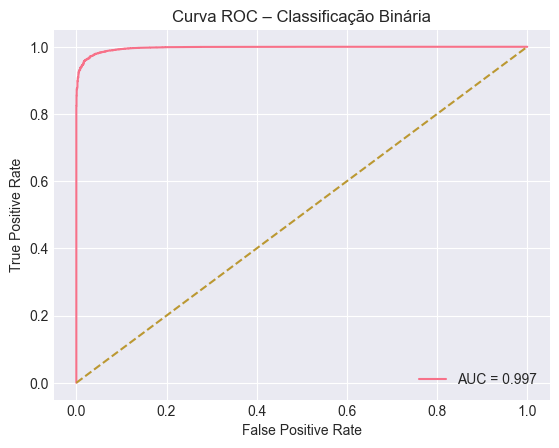

In [30]:
y_prob_rf_bin = rf_bin.predict_proba(X_test_bin)[:, 1]

fpr, tpr, _ = roc_curve(y_test_bin, y_prob_rf_bin)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Classificação Binária")
plt.legend()
plt.show()

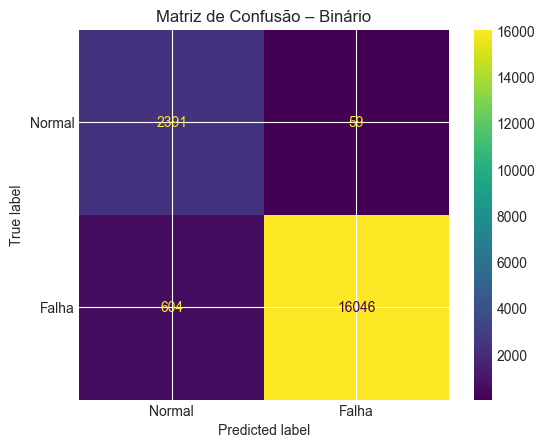

In [31]:
y_pred_bin = rf_bin.predict(X_test_bin)

cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_bin,
    display_labels=["Normal", "Falha"]
)

disp.plot()
plt.title("Matriz de Confusão – Binário")
plt.show()

Rondom Forest Multiclass

In [32]:
rf_multi = RandomForestClassifier(
    n_estimators=300,
    max_depth=24,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # importante para multiclasse
)

rf_multi.fit(X_train, y_train.values.ravel())

y_pred_rf_multi = rf_multi.predict(X_test)

print("=== Random Forest (Multiclasse) ===")
print(classification_report(y_test,y_pred_rf_multi))
print("Matriz de Confusão:")

=== Random Forest (Multiclasse) ===
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2450
           1       0.62      0.85      0.71      2450
           2       0.59      0.66      0.62      2400
           3       0.61      0.55      0.58      2400
           4       0.60      0.55      0.57      2450
           5       0.67      0.58      0.62      2350
           6       0.79      0.76      0.77      2350
           7       0.91      0.80      0.85      2250

    accuracy                           0.71     19100
   macro avg       0.72      0.71      0.71     19100
weighted avg       0.71      0.71      0.71     19100

Matriz de Confusão:


In [33]:
cv_scores = cross_val_score(
    rf_multi,
    X_train,
    y_train.values.ravel(),
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"RF Multiclasse - F1 macro (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

RF Multiclasse - F1 macro (CV): 0.693 ± 0.003


In [34]:
importances = pd.Series(
    rf_multi.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importances)

4    0.161496
3    0.158270
2    0.148019
0    0.126382
7    0.126174
1    0.108792
6    0.085859
5    0.085008
dtype: float64


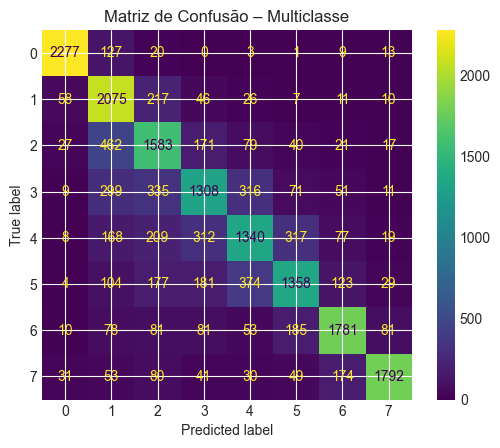

In [35]:
y_pred_multi = rf_multi.predict(X_test)

cm_multi = confusion_matrix(y_test, y_pred_multi)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_multi
)

disp.plot()
plt.title("Matriz de Confusão – Multiclasse")
plt.show()

## 4.2 Modelo 2: LightGBM

O LightGBM foi selecionado como segundo modelo por representar uma abordagem mais sofisticada de arvores de decisão, baseada em Gradient Boosting, adequada para extrair padrões mais sutis dos dados.
Assim como o Random Forest, o LightGBM não depende de distribuições normais.
É especialmente eficiente em dados tabulares com multiplas variaveis correlacionadas.
O mecanismo de boosting permite que o modelo foque iterativamente nos erros cometidos, o que é particularmente util para diferenciar niveis próximos de desbalanceamento.

LightGBM Binario

In [36]:
lgb_bin = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=256,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=32,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_bin.fit(X_train_bal, y_train_bal)

y_pred_lgb = lgb_bin.predict(X_test_bin)
y_prob_lgb = lgb_bin.predict_proba(X_test_bin)

[LightGBM] [Info] Number of positive: 9800, number of negative: 9800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 19600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [37]:
acc_lgb_bin = accuracy_score(y_test_bin, y_pred_lgb)
loss_lgb_bin = log_loss(y_test_bin, y_prob_lgb)

In [38]:
cv_lgb_bin = cross_val_score(
    lgb_bin,
    X_train_bal,
    y_train_bal,
    cv=5,
    scoring="recall"
)

[LightGBM] [Info] Number of positive: 7840, number of negative: 7840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 15680, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7840, number of negative: 7840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 15680, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7840, number of negative: 

In [39]:
print("=== LIGHTGBM BINARIO ===")
print(classification_report(y_test_bin, y_pred_lgb))
print(f"Acurácia: {acc_lgb_bin:.4f}")
print(f"Log-loss: {loss_lgb_bin:.4f}")
print(f"Recall CV: {cv_lgb_bin.mean():.4f} ± {cv_lgb_bin.std():.4f}")

=== LIGHTGBM BINARIO ===
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2450
           1       1.00      0.97      0.98     16650

    accuracy                           0.97     19100
   macro avg       0.91      0.97      0.94     19100
weighted avg       0.97      0.97      0.97     19100

Acurácia: 0.9690
Log-loss: 0.0692
Recall CV: 0.9697 ± 0.0029


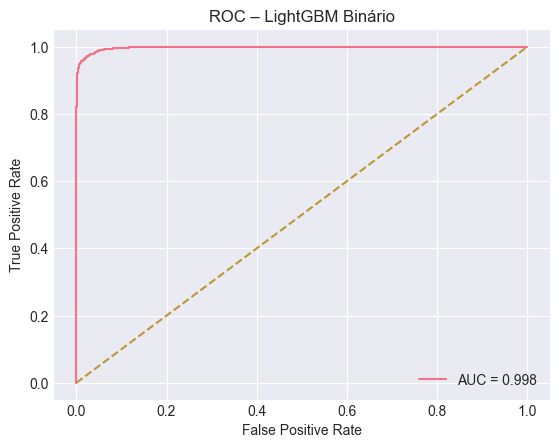

In [40]:
y_prob_lgb_bin = lgb_bin.predict_proba(X_test_bin)[:, 1]

fpr_bin, tpr_bin, _ = roc_curve(y_test_bin, y_prob_lgb_bin)
roc_auc = auc(fpr_bin, tpr_bin)

plt.figure()
plt.plot(fpr_bin, tpr_bin, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – LightGBM Binário")
plt.legend()
plt.show()

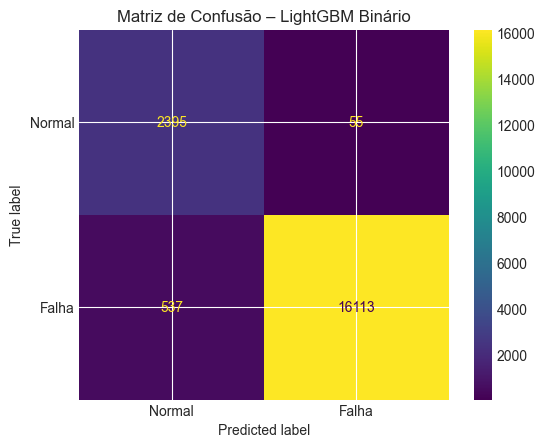

In [41]:
cm_lgb_bin = confusion_matrix(y_test_bin, y_pred_lgb)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lgb_bin,
    display_labels=["Normal", "Falha"]
)

disp.plot()
plt.title("Matriz de Confusão – LightGBM Binário")
plt.show()

LightGBM Multiclass

In [42]:
lgb_multi = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=8,
    n_estimators=512,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_multi.fit(X_train, y_train.values.ravel())

y_pred_lgb_m = lgb_multi.predict(X_test)
y_prob_lgb_m = lgb_multi.predict_proba(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 76400, number of used features: 8
[LightGBM] [Info] Start training from score -2.053600
[LightGBM] [Info] Start training from score -2.053600
[LightGBM] [Info] Start training from score -2.074220
[LightGBM] [Info] Start training from score -2.074220
[LightGBM] [Info] Start training from score -2.053600
[LightGBM] [Info] Start training from score -2.095273
[LightGBM] [Info] Start training from score -2.095273
[LightGBM] [Info] Start training from score -2.138758


In [43]:
acc_lgb_m = accuracy_score(y_test, y_pred_lgb_m)
loss_lgb_m = log_loss(y_test, y_prob_lgb_m)

In [44]:
cv_lgb_m = cross_val_score(
    lgb_multi,
    X_train,
    y_train.values.ravel(),
    cv=5,
    scoring="f1_macro"
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 61120, number of used features: 8
[LightGBM] [Info] Start training from score -2.053600
[LightGBM] [Info] Start training from score -2.053600
[LightGBM] [Info] Start training from score -2.074220
[LightGBM] [Info] Start training from score -2.074220
[LightGBM] [Info] Start training from score -2.053600
[LightGBM] [Info] Start training from score -2.095273
[LightGBM] [Info] Start training from score -2.095273
[LightGBM] [Info] Start training from score -2.138758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 61120, number of used feat

In [45]:
print("=== LIGHTGBM MULTICLASSE ===")
print(classification_report(y_test, y_pred_lgb_m))
print(f"Acurácia: {acc_lgb_m:.4f}")
print(f"Log-loss: {loss_lgb_m:.4f}")
print(f"F1 macro CV: {cv_lgb_m.mean():.4f} ± {cv_lgb_m.std():.4f}")

=== LIGHTGBM MULTICLASSE ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2450
           1       0.71      0.84      0.77      2450
           2       0.61      0.68      0.64      2400
           3       0.59      0.59      0.59      2400
           4       0.58      0.55      0.57      2450
           5       0.65      0.59      0.61      2350
           6       0.81      0.78      0.80      2350
           7       0.92      0.82      0.86      2250

    accuracy                           0.72     19100
   macro avg       0.73      0.72      0.72     19100
weighted avg       0.73      0.72      0.72     19100

Acurácia: 0.7235
Log-loss: 0.7381
F1 macro CV: 0.7066 ± 0.0027


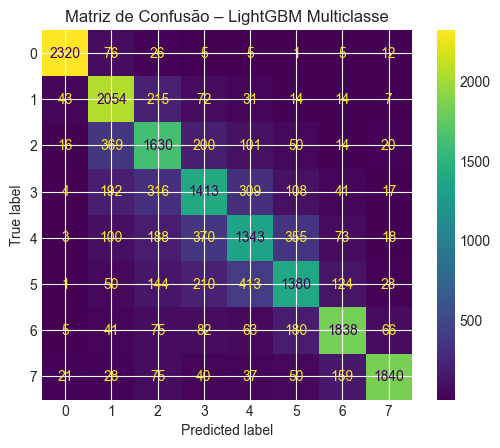

In [46]:
cm_lgb_multi = confusion_matrix(y_test, y_pred_lgb_m)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb_multi)
disp.plot()
plt.title("Matriz de Confusão – LightGBM Multiclasse")
plt.show()

**Interpretação dos resultados**

Criei dois cenarios, detecção de falha binario e multiclasses. 


No cenario binario (normal vs falha), ambos os modelos apresentaram desempenho elevado, com recall superior a 96% para a classe de falha, caracteristica essencial em aplicações de manutenção preditiva, onde falsos negativos devem ser minimizados.

No cenario multiclasse, observou-se maior dificuldade na distinção entre niveis proximos de desbalanceamento, como 10g, 15g e 20g, refletindo a semelhança física dos sinais. Ainda assim, o LightGBM apresentou desempenho ligeiramente superior em F1 macro, indicando melhor equilibrio entre precisão e recall nas classes minoritarias, e na distinção entre niveis proximos.